# Pharmaceutical Reviews - 03 - Clustering, Evaluation & Conclusion

Below, I will use K-means in order to cluster the data for the subsets defined in previous notebooks. I then use the silhoutte score for evaluation, and discuss my general findings. 

## Data Import

In [334]:
#imports necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score

In [335]:
file_path = '../data/drugsCom_CLEAN.csv'

reviews = pd.read_csv(file_path)

In [336]:
pain = reviews.loc[reviews['condition'] == 'Pain']

pain.head()

drug condition                                             review  \
1043     Ibudone      Pain  "I just started taking this medicine.  I have ...   
1048  Ultram ODT      Pain  "You can use ultram to detox yourself from har...   
1053  Ultram ODT      Pain  "I have been using tramadol for eight years fo...   
1944     Belbuca      Pain  "I was on Fentynal  patches for year and a hal...   
2110     Talacen      Pain  "I have rheumatoid arthritis and a few other b...   

      rating  usefulcount  
1043     7.0           27  
1048    10.0           28  
1053    10.0          105  
1944     1.0           14  
2110     9.0           12

In [337]:
pain.shape

(6145, 5)

In [338]:
pain.rating.mean()

7.6322213181448335

In [339]:
pain = pain.drop(columns = 'condition')

pain.columns

Index(['drug', 'review', 'rating', 'usefulcount'], dtype='object')

In [340]:
sia = SentimentIntensityAnalyzer()

In [341]:
scores = [sia.polarity_scores(word) for word in pain['review']]

scores_sentiments = pd.DataFrame(scores)

scores_sentiments.head()

neg    neu    pos  compound
0  0.203  0.797  0.000   -0.9633
1  0.081  0.741  0.178    0.4939
2  0.195  0.777  0.028   -0.9141
3  0.092  0.834  0.075   -0.2298
4  0.125  0.821  0.054   -0.5093

In [342]:
scores_sentiments.shape

(6145, 4)

In [343]:
scores_sentiments.isnull().sum()

neg         0
neu         0
pos         0
compound    0
dtype: int64

I will now add the scores into the pain dataframe.

In [344]:
drugs = pain.drug.values.tolist()

drugs = pd.DataFrame(drugs)

drugs.rename(columns = {0: 'drug'}, inplace = True)

drugs.head()

drug
0     Ibudone
1  Ultram ODT
2  Ultram ODT
3     Belbuca
4     Talacen

In [345]:
drugs.shape

(6145, 1)

In [346]:
words = pain.review.values.tolist()

words = pd.DataFrame(words)

words.rename(columns = {0: 'review'}, inplace = True)

words.head()

review
0  "I just started taking this medicine.  I have ...
1  "You can use ultram to detox yourself from har...
2  "I have been using tramadol for eight years fo...
3  "I was on Fentynal  patches for year and a hal...
4  "I have rheumatoid arthritis and a few other b...

In [347]:
words.shape

(6145, 1)

In [348]:
usefulcounts = pain.usefulcount.values.tolist()

usefulcounts = pd.DataFrame(usefulcounts)

usefulcounts.rename(columns = {0: 'usefulcount'}, inplace = True)

usefulcounts.head()

usefulcount
0           27
1           28
2          105
3           14
4           12

In [349]:
ratings = pain.rating.values.tolist()

ratings = pd.DataFrame(ratings)

ratings.rename(columns = {0: 'rating'}, inplace = True)

ratings.head()

rating
0     7.0
1    10.0
2    10.0
3     1.0
4     9.0

In [350]:
ratings.shape

(6145, 1)

In [351]:
pain_sentiments = pd.concat([drugs, words, scores_sentiments, usefulcounts, ratings], axis=1)

pain_sentiments.head()

drug                                             review    neg  \
0     Ibudone  "I just started taking this medicine.  I have ...  0.203   
1  Ultram ODT  "You can use ultram to detox yourself from har...  0.081   
2  Ultram ODT  "I have been using tramadol for eight years fo...  0.195   
3     Belbuca  "I was on Fentynal  patches for year and a hal...  0.092   
4     Talacen  "I have rheumatoid arthritis and a few other b...  0.125   

     neu    pos  compound  usefulcount  rating  
0  0.797  0.000   -0.9633           27     7.0  
1  0.741  0.178    0.4939           28    10.0  
2  0.777  0.028   -0.9141          105    10.0  
3  0.834  0.075   -0.2298           14     1.0  
4  0.821  0.054   -0.5093           12     9.0

In [352]:
pain_sentiments.isnull().sum()

drug           0
review         0
neg            0
neu            0
pos            0
compound       0
usefulcount    0
rating         0
dtype: int64

In [353]:
pain_sentiments.shape

(6145, 8)

In [354]:
pain = pain_sentiments

pain.head()

drug                                             review    neg  \
0     Ibudone  "I just started taking this medicine.  I have ...  0.203   
1  Ultram ODT  "You can use ultram to detox yourself from har...  0.081   
2  Ultram ODT  "I have been using tramadol for eight years fo...  0.195   
3     Belbuca  "I was on Fentynal  patches for year and a hal...  0.092   
4     Talacen  "I have rheumatoid arthritis and a few other b...  0.125   

     neu    pos  compound  usefulcount  rating  
0  0.797  0.000   -0.9633           27     7.0  
1  0.741  0.178    0.4939           28    10.0  
2  0.777  0.028   -0.9141          105    10.0  
3  0.834  0.075   -0.2298           14     1.0  
4  0.821  0.054   -0.5093           12     9.0

The main dataset has been prepared. I will now proceed with modeling.

## K - Means Clustering

I am interested to what insights clusters created through K - Means might provide. First, I will re-create the previously used datasets below>

### Creating the Datasets

#### Reviews with Ratings of 10 v. Reviews with Ratings of 1

In [355]:
pain_hl = pain.loc[(pain['rating'] == 1) | (pain['rating'] == 10)]

pain_hl = pd.DataFrame(pain_hl)

pain_hl.head()

drug                                             review    neg  \
1       Ultram ODT  "You can use ultram to detox yourself from har...  0.081   
2       Ultram ODT  "I have been using tramadol for eight years fo...  0.195   
3          Belbuca  "I was on Fentynal  patches for year and a hal...  0.092   
6  Lorcet 10 / 650  "This pill has allowed me to get some much nee...  0.142   
9    Darvocet A500  "I have Anklosing spondylitis, arthritis in ma...  0.000   

     neu    pos  compound  usefulcount  rating  
1  0.741  0.178    0.4939           28    10.0  
2  0.777  0.028   -0.9141          105    10.0  
3  0.834  0.075   -0.2298           14     1.0  
6  0.756  0.102   -0.6597            9    10.0  
9  0.948  0.052    0.0951           19     1.0

In [356]:
pain_hl.rating.replace({10:0}, inplace = True)

In [357]:
pain_hl.rating.value_counts(normalize = True)

0.0    0.783643
1.0    0.216357
Name: rating, dtype: float64

#### 10 Common v. 1 Common

In [358]:
common = pain.loc[(pain['drug'] == 'Oxycodone') | (pain['drug'] == 'Acetaminophen / oxycodone') |
                     (pain['drug'] == 'Acetaminophen / hydrocodone')|(pain['drug'] == 'Hydromorphone')|
                    (pain['drug'] == 'Dilaudid') | (pain['drug'] == 'Tramadol') | (pain['drug'] == 'Tapentadol') |
                     (pain['drug'] == 'Acetaminophen / codeine')|(pain['drug'] == 'Gabapentin')|
                    (pain['drug'] == 'Nucynta')]

common = pd.DataFrame(common)
common.head()


drug                                             review    neg    neu  \
235  Nucynta  "I have severe, constant pain following 4 seri...  0.136  0.814   
236  Nucynta  "This has worked great for me. Manages my pain...  0.140  0.698   
237  Nucynta  "I have severe IC. This is the only Med that m...  0.157  0.819   
238  Nucynta  "I have a form of muscular dystrophy and take ...  0.186  0.717   
239  Nucynta  "DO NOT TAKE THIS PILL...!!\r\nIF YOU HAVE ANY...  0.232  0.631   

       pos  compound  usefulcount  rating  
235  0.050   -0.7884           29     5.0  
236  0.163    0.0258           31     8.0  
237  0.024   -0.8271           22     8.0  
238  0.097   -0.8736           26    10.0  
239  0.138   -0.8894           33     1.0

In [359]:
common.shape

(2215, 8)

In [360]:
common.drug.value_counts()

Tramadol                       357
Acetaminophen / hydrocodone    332
Oxycodone                      281
Acetaminophen / oxycodone      249
Tapentadol                     216
Hydromorphone                  187
Gabapentin                     176
Nucynta                        164
Dilaudid                       159
Acetaminophen / codeine         94
Name: drug, dtype: int64

In [361]:
common.isnull().sum()

drug           0
review         0
neg            0
neu            0
pos            0
compound       0
usefulcount    0
rating         0
dtype: int64

The dataset appears to be correct. I will now create classes, ten common (0) and one common (1).

In [362]:
common['class'] = np.nan

common.head()

drug                                             review    neg    neu  \
235  Nucynta  "I have severe, constant pain following 4 seri...  0.136  0.814   
236  Nucynta  "This has worked great for me. Manages my pain...  0.140  0.698   
237  Nucynta  "I have severe IC. This is the only Med that m...  0.157  0.819   
238  Nucynta  "I have a form of muscular dystrophy and take ...  0.186  0.717   
239  Nucynta  "DO NOT TAKE THIS PILL...!!\r\nIF YOU HAVE ANY...  0.232  0.631   

       pos  compound  usefulcount  rating  class  
235  0.050   -0.7884           29     5.0    NaN  
236  0.163    0.0258           31     8.0    NaN  
237  0.024   -0.8271           22     8.0    NaN  
238  0.097   -0.8736           26    10.0    NaN  
239  0.138   -0.8894           33     1.0    NaN

In [363]:
common.loc[(common['drug'] == 'Oxycodone') | (common['drug'] == 'Acetaminophen / oxycodone') |
                     (common['drug'] == 'Acetaminophen / hydrocodone')|(common['drug'] == 'Hydromorphone')|
                    (common['drug'] == 'Dilaudid'), 'class'] = 0

common.loc[(common['drug'] == 'Tramadol') | (common['drug'] == 'Tapentadol') |
                     (common['drug'] == 'Acetaminophen / codeine')|(common['drug'] == 'Gabapentin')|
                    (common['drug'] == 'Nucynta'), 'class'] = 1

common.head()

drug                                             review    neg    neu  \
235  Nucynta  "I have severe, constant pain following 4 seri...  0.136  0.814   
236  Nucynta  "This has worked great for me. Manages my pain...  0.140  0.698   
237  Nucynta  "I have severe IC. This is the only Med that m...  0.157  0.819   
238  Nucynta  "I have a form of muscular dystrophy and take ...  0.186  0.717   
239  Nucynta  "DO NOT TAKE THIS PILL...!!\r\nIF YOU HAVE ANY...  0.232  0.631   

       pos  compound  usefulcount  rating  class  
235  0.050   -0.7884           29     5.0    1.0  
236  0.163    0.0258           31     8.0    1.0  
237  0.024   -0.8271           22     8.0    1.0  
238  0.097   -0.8736           26    10.0    1.0  
239  0.138   -0.8894           33     1.0    1.0

In [364]:
common['class'].value_counts()

0.0    1208
1.0    1007
Name: class, dtype: int64

In [365]:
common.isnull().sum()

drug           0
review         0
neg            0
neu            0
pos            0
compound       0
usefulcount    0
rating         0
class          0
dtype: int64

In [366]:
common.drug.unique()

array(['Nucynta', 'Tramadol', 'Acetaminophen / oxycodone',
       'Hydromorphone', 'Acetaminophen / codeine', 'Tapentadol',
       'Gabapentin', 'Acetaminophen / hydrocodone', 'Dilaudid',
       'Oxycodone'], dtype=object)

In [367]:
common['class'].value_counts(normalize = True)

0.0    0.545372
1.0    0.454628
Name: class, dtype: float64

#### Oxycodone v. Tramadol

I would like to see if I can predict whether a review is for Oxycodone or Tramadol. Oxycodone has a higher mean rating at 8.86, compared to Tramadol's 6.51.

In [368]:
oxytram = pain.loc[(pain['drug'] == 'Oxycodone') | (pain['drug'] == 'Tramadol')]

oxytram = pd.DataFrame(oxytram)

oxytram.head()

drug                                             review    neg  \
707  Tramadol  "I was on 7.5/500 Hydrocodone 6-8 x daily for ...  0.238   
708  Tramadol  "I have rheumatoid arthritis, recently diagnos...  0.131   
709  Tramadol  "This is an exceptional drug for pain relief b...  0.226   
710  Tramadol  "I use Tramadol for chronic back pain. At time...  0.074   
711  Tramadol  "I DID NOT have a good experience with this me...  0.156   

       neu    pos  compound  usefulcount  rating  
707  0.686  0.076   -0.9773           36    10.0  
708  0.721  0.147    0.1280           16     8.0  
709  0.566  0.208   -0.2500           23     3.0  
710  0.856  0.070   -0.0516            8     8.0  
711  0.746  0.098   -0.7169           11     1.0

In [369]:
oxytram.shape

(638, 8)

In [370]:
oxytram.drug.value_counts()

Tramadol     357
Oxycodone    281
Name: drug, dtype: int64

The preliminary datasets have been created. I will make further changes in processing for K-means as shown below.

## K - Means

I am interested to see how the data can be separated using K means. I will explore below.

### Reviews with Ratings of 10 and 1

In [371]:
pain_hl.head()

drug                                             review    neg  \
1       Ultram ODT  "You can use ultram to detox yourself from har...  0.081   
2       Ultram ODT  "I have been using tramadol for eight years fo...  0.195   
3          Belbuca  "I was on Fentynal  patches for year and a hal...  0.092   
6  Lorcet 10 / 650  "This pill has allowed me to get some much nee...  0.142   
9    Darvocet A500  "I have Anklosing spondylitis, arthritis in ma...  0.000   

     neu    pos  compound  usefulcount  rating  
1  0.741  0.178    0.4939           28     0.0  
2  0.777  0.028   -0.9141          105     0.0  
3  0.834  0.075   -0.2298           14     1.0  
6  0.756  0.102   -0.6597            9     0.0  
9  0.948  0.052    0.0951           19     1.0

##### Pre-processing Data

In [372]:
pain_hl_k = pain_hl.set_index('drug')

pain_hl_k.head()

review    neg  \
drug                                                                        
Ultram ODT       "You can use ultram to detox yourself from har...  0.081   
Ultram ODT       "I have been using tramadol for eight years fo...  0.195   
Belbuca          "I was on Fentynal  patches for year and a hal...  0.092   
Lorcet 10 / 650  "This pill has allowed me to get some much nee...  0.142   
Darvocet A500    "I have Anklosing spondylitis, arthritis in ma...  0.000   

                   neu    pos  compound  usefulcount  rating  
drug                                                          
Ultram ODT       0.741  0.178    0.4939           28     0.0  
Ultram ODT       0.777  0.028   -0.9141          105     0.0  
Belbuca          0.834  0.075   -0.2298           14     1.0  
Lorcet 10 / 650  0.756  0.102   -0.6597            9     0.0  
Darvocet A500    0.948  0.052    0.0951           19     1.0

In [373]:
pain_hl_k = pain_hl_k.drop(columns = ['review'])

pain_hl_k.head()

neg    neu    pos  compound  usefulcount  rating
drug                                                               
Ultram ODT       0.081  0.741  0.178    0.4939           28     0.0
Ultram ODT       0.195  0.777  0.028   -0.9141          105     0.0
Belbuca          0.092  0.834  0.075   -0.2298           14     1.0
Lorcet 10 / 650  0.142  0.756  0.102   -0.6597            9     0.0
Darvocet A500    0.000  0.948  0.052    0.0951           19     1.0

I am ready to begin the process.

##### Create and scale features

In [374]:
X = pain_hl_k[['compound', 'usefulcount']]

ss = StandardScaler()

X = ss.fit_transform(X)

*Use of additional features leads to a lower silhoutte score.*

##### Fit & instantiate 

In [375]:
km = KMeans(n_clusters = 2, random_state = 6789) 
km.fit(X)


KMeans(n_clusters=2, random_state=6789)

In [376]:
km.cluster_centers_

array([[-7.24785033e-01,  4.93655483e-04],
       [ 1.10761322e+00, -7.54402081e-04]])

In [377]:
pain_hl_k2 = pain_hl_k.copy()

In [378]:
# Attach predicted cluster to original points

pain_hl_k2['cluster'] = km.labels_
pain_hl_k2.head()

neg    neu    pos  compound  usefulcount  rating  cluster
drug                                                                        
Ultram ODT       0.081  0.741  0.178    0.4939           28     0.0        1
Ultram ODT       0.195  0.777  0.028   -0.9141          105     0.0        0
Belbuca          0.092  0.834  0.075   -0.2298           14     1.0        0
Lorcet 10 / 650  0.142  0.756  0.102   -0.6597            9     0.0        0
Darvocet A500    0.000  0.948  0.052    0.0951           19     1.0        1

In [379]:
# Reverses scaling transformation
ss.inverse_transform(km.cluster_centers_)

array([[-0.69335959, 37.46740467],
       [ 0.44335216, 37.40977444]])

In [380]:
## Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0          1
0 -0.693360  37.467405
1  0.443352  37.409774

##### Evaluate

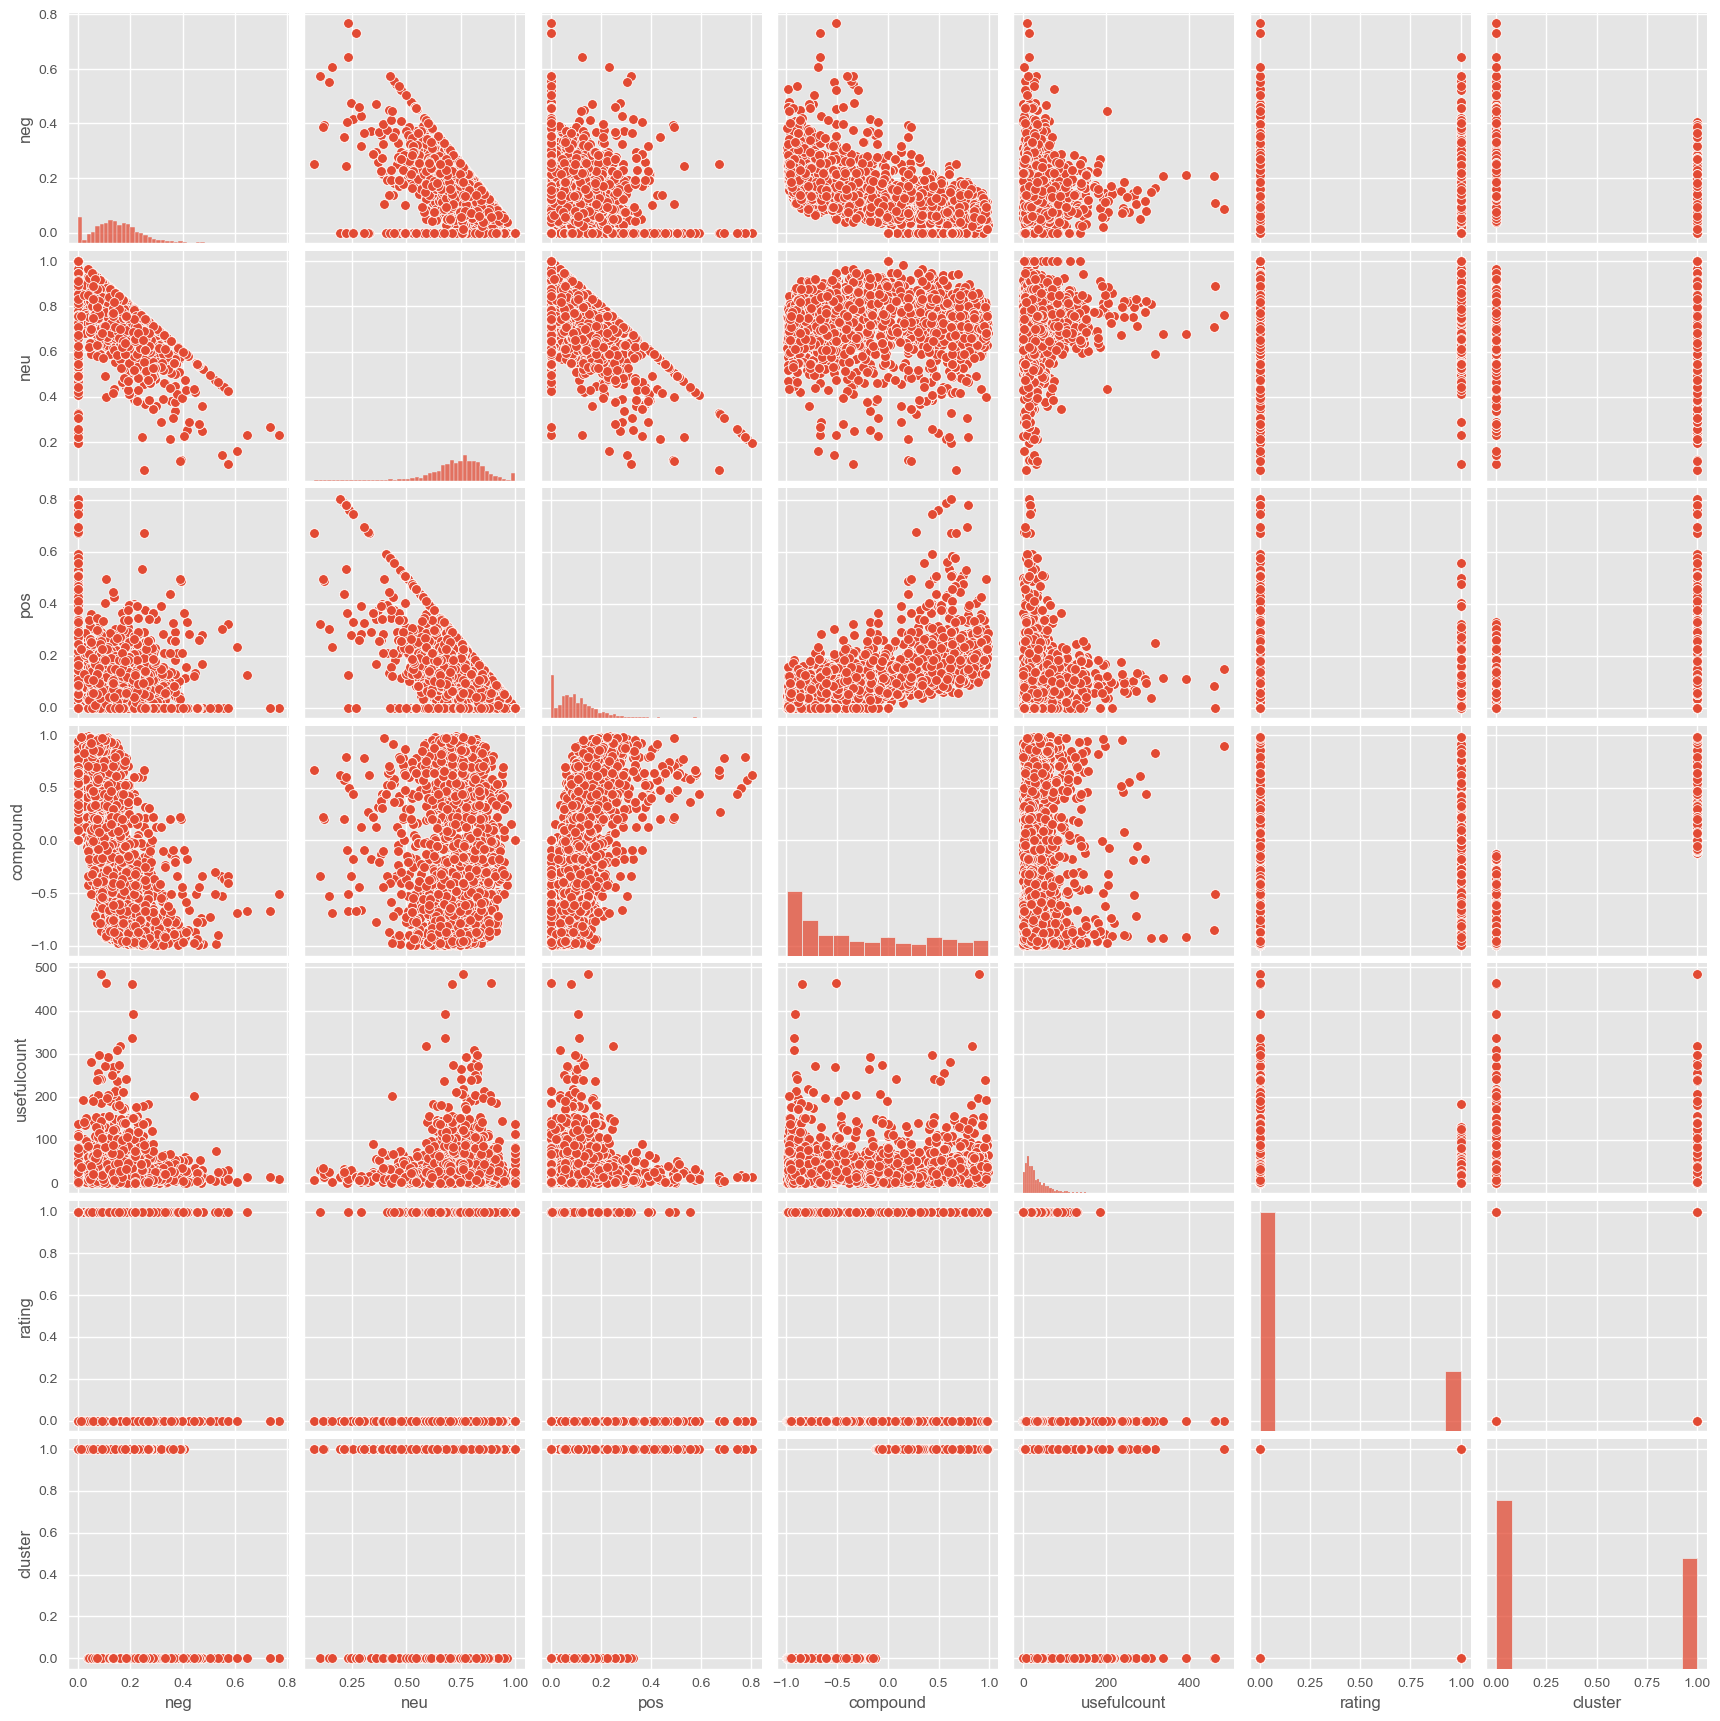

In [381]:
import plotly.express as px
plt.style.use('ggplot')

sns.pairplot(pain_hl_k2);

In [382]:
print(pain_hl_k2.groupby(['cluster']).mean())

              neg       neu       pos  compound  usefulcount    rating
cluster                                                               
0        0.194528  0.737929  0.067549 -0.693360    37.467405  0.268758
1        0.085557  0.733176  0.181273  0.443352    37.409774  0.136278


The most noticeable difference between the two groups is the mean compound score, which is -0.693 one cluster, and 0.443 in the other.

In [383]:
pain_hl_k2.groupby('cluster')['rating'].mean()

cluster
0    0.268758
1    0.136278
Name: rating, dtype: float64

In [384]:
pain_hl_k2.cluster.value_counts(normalize = True)

0    0.604461
1    0.395539
Name: cluster, dtype: float64

Approximately 60% of the reviews fall into Cluster 0, while the remaining 40% fall into Cluster 1.

In [385]:
silhouette_score(X, km.labels_)

0.4911087959881269

This score is close to 0.5, so the clusters are moderately well-defined. For the 2 clusters based on compound score and useful count:

One cluster has a a strongly negative compound score, and higher ratio of 10-rated to 1-rated reviews.

The other cluster has a moderately positive compound score, and lower ration of 10-rated to 1-rated reviews.

Further exploration could prove beneficial for someone seeking for additional information beyond the known variables.

Below, I will use an elbow plot to determine which k value would be optimal.

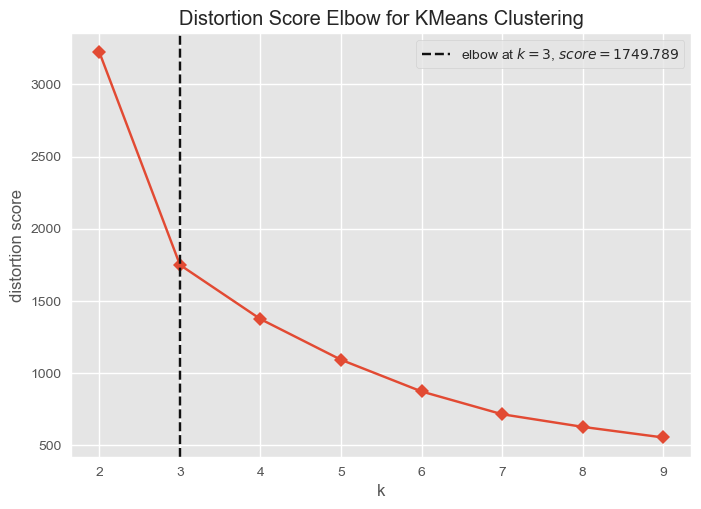

In [386]:
from yellowbrick.cluster import (InterclusterDistance, KElbowVisualizer, 
                                 SilhouetteVisualizer)

model = KMeans()

visualizer =  KElbowVisualizer(model, k=(2,10),timings=False)
visualizer.fit(X)
visualizer.show();

It appears that the optimal value for k is 3. I will run another model in which k = 3 to observe the attributes of the clusters.

##### Fit & Instantiate

In [387]:
km = KMeans(n_clusters = 3, random_state = 6789) 
km.fit(X)


KMeans(n_clusters=3, random_state=6789)

In [388]:
km.cluster_centers_

array([[-0.7228239 , -0.17626178],
       [ 1.10817602, -0.17668532],
       [ 0.02220849,  3.33907662]])

In [389]:
pain_hl_k3 = pain_hl_k.copy()

In [390]:
# Attach predicted cluster to original points

pain_hl_k3['cluster'] = km.labels_
pain_hl_k3.head()

neg    neu    pos  compound  usefulcount  rating  cluster
drug                                                                        
Ultram ODT       0.081  0.741  0.178    0.4939           28     0.0        1
Ultram ODT       0.195  0.777  0.028   -0.9141          105     0.0        0
Belbuca          0.092  0.834  0.075   -0.2298           14     1.0        0
Lorcet 10 / 650  0.142  0.756  0.102   -0.6597            9     0.0        0
Darvocet A500    0.000  0.948  0.052    0.0951           19     1.0        1

In [391]:
# Reverses scaling transformation
ss.inverse_transform(km.cluster_centers_)

array([[ -0.69214302,  29.30555556],
       [  0.44370129,  29.28599801],
       [ -0.22996889, 191.62962963]])

In [392]:
## Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0           1
0 -0.692143   29.305556
1  0.443701   29.285998
2 -0.229969  191.629630

In [393]:
## Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0           1
0 -0.692143   29.305556
1  0.443701   29.285998
2 -0.229969  191.629630

##### Evaluate

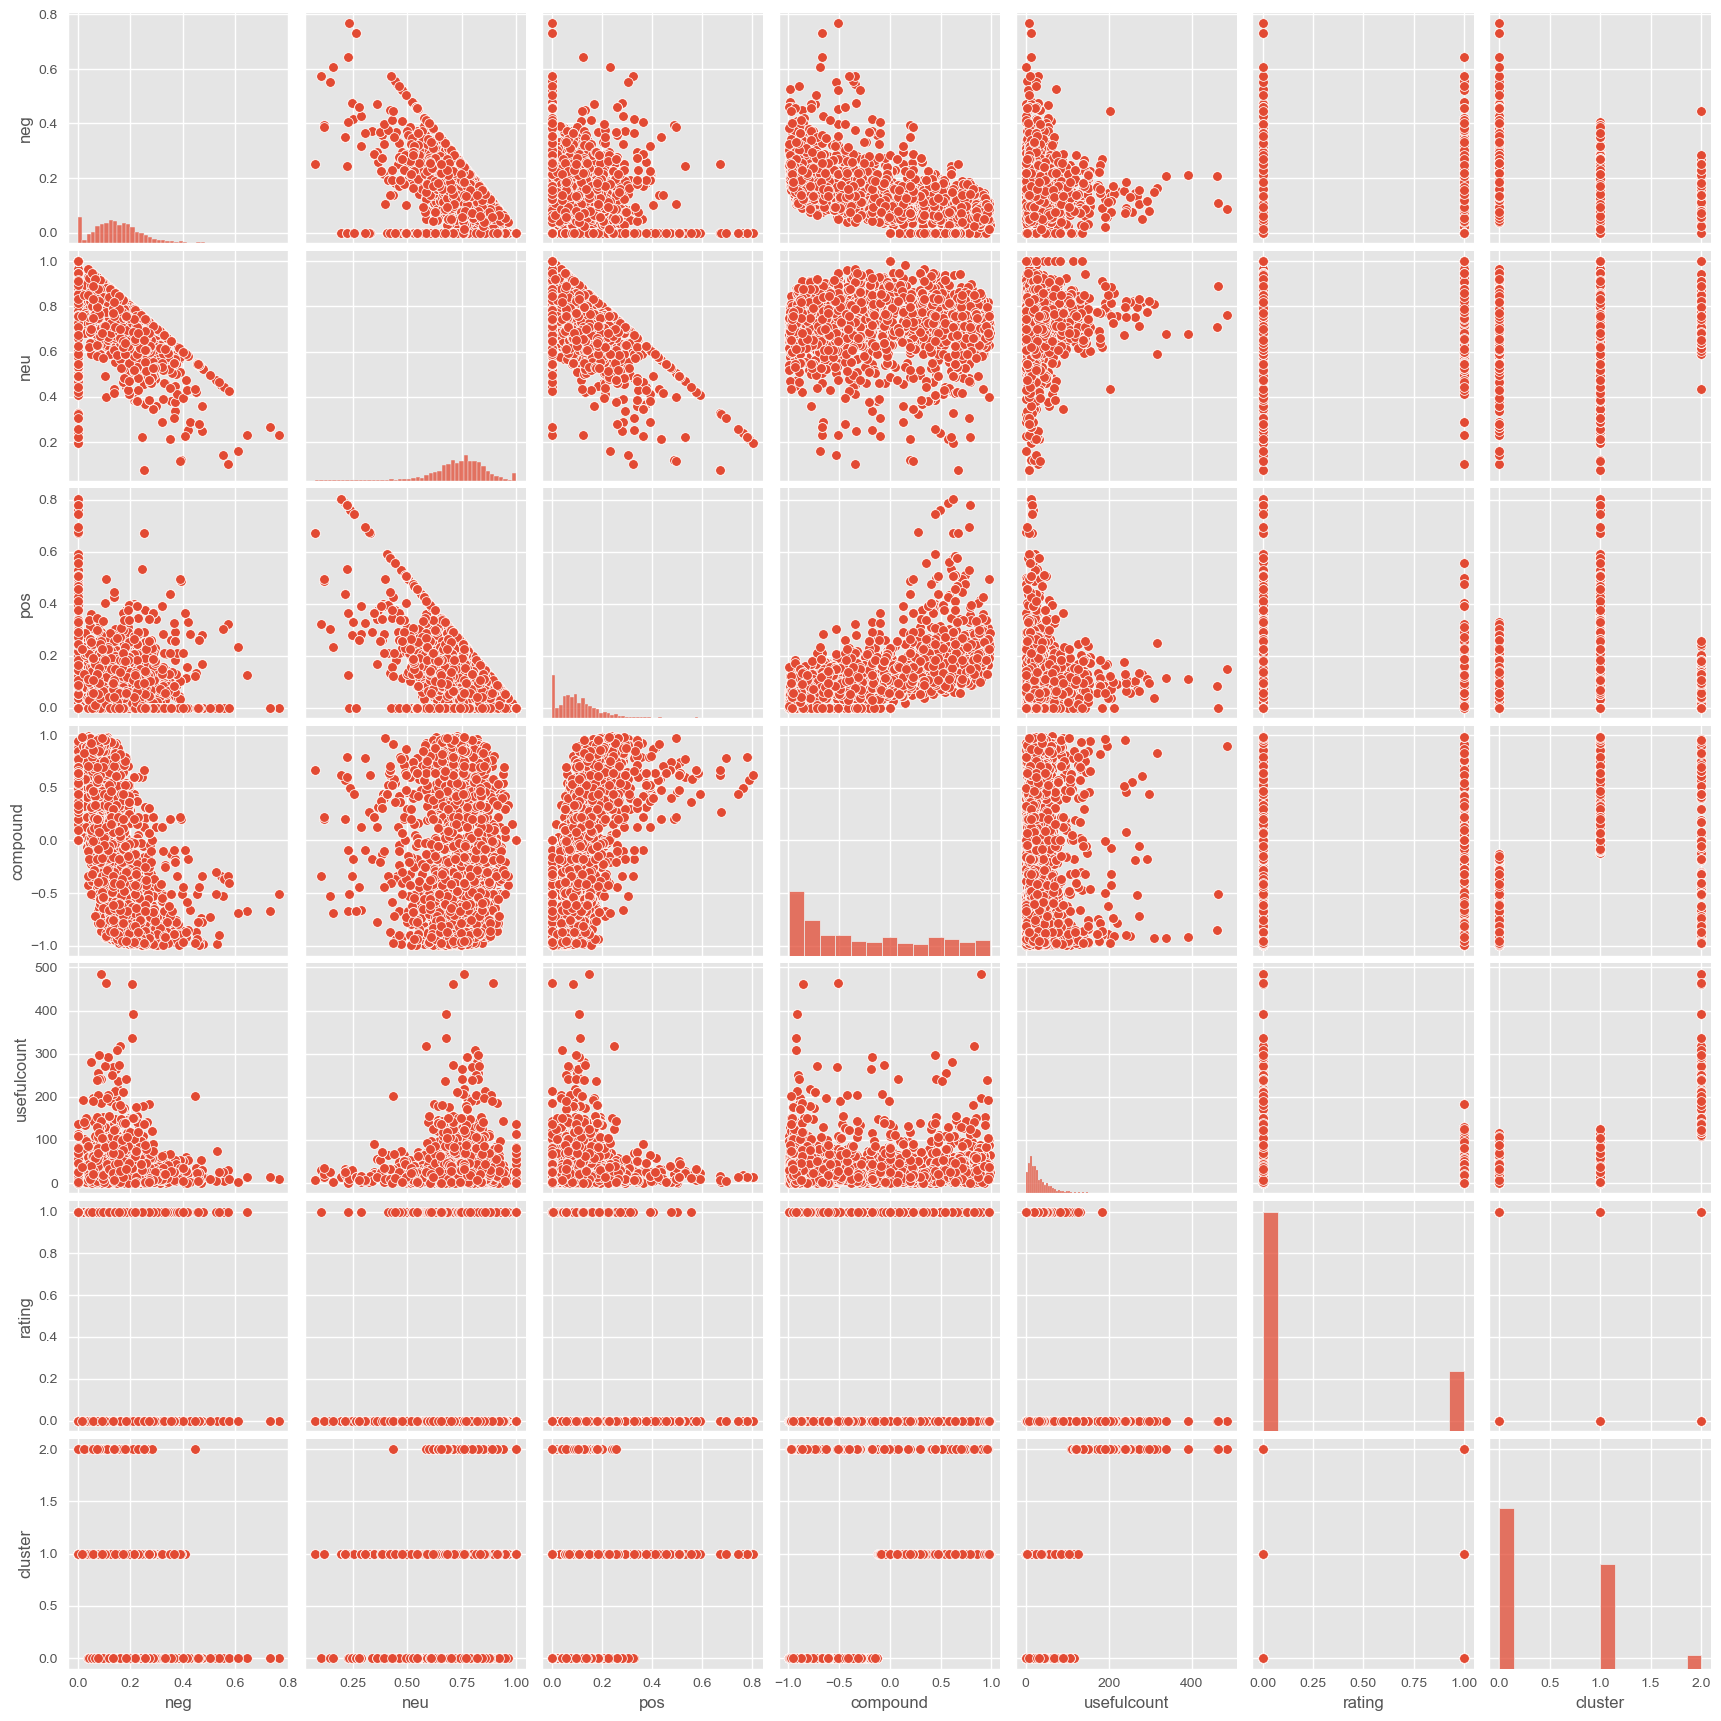

In [394]:
sns.pairplot(pain_hl_k3);

In [395]:
print(pain_hl_k3.groupby(['cluster']).mean())

              neg       neu       pos  compound  usefulcount    rating
cluster                                                               
0        0.195596  0.737418  0.066993 -0.692143    29.305556  0.278424
1        0.084855  0.731847  0.183302  0.443701    29.285998  0.142999
2        0.141519  0.751689  0.106815 -0.229969   191.629630  0.051852


In [396]:
pain_hl_k3.cluster.value_counts(normalize = True)

0    0.575465
1    0.374349
2    0.050186
Name: cluster, dtype: float64

Here, there is a very uneven split. The cluster with the very high useful count represents only 0.05 of the total reviews.

In [397]:
silhouette_score(X, km.labels_) #shows score for the 3 cluster data

0.5379827130034125

These reviews are clustered based on compound score and useful count.

One cluster has a strongly negative compound score and low useful count (and highest ratio of 10-rated reviews to 1-rated reviews.)

Another cluster has a positive compound score and low useful count (and medium ratio of 10-rated reviews to 1-rated reviews.)

The third cluster has a slightly negative compound score and a very high useful count (and lowest ratio of 10-rated reviews to 1-rated reviews.)


With a score of greater than 0.5, the clusters are moderately well-defined, and may be of some use to those seeking patterns in the data other than the variables already assigned. For example, there is a small cluster with a very high useful count average, so it could be studied to determine what information patients are most seeking.

### Ten Common & 1 Common Drugs

In [398]:
common.head()

drug                                             review    neg    neu  \
235  Nucynta  "I have severe, constant pain following 4 seri...  0.136  0.814   
236  Nucynta  "This has worked great for me. Manages my pain...  0.140  0.698   
237  Nucynta  "I have severe IC. This is the only Med that m...  0.157  0.819   
238  Nucynta  "I have a form of muscular dystrophy and take ...  0.186  0.717   
239  Nucynta  "DO NOT TAKE THIS PILL...!!\r\nIF YOU HAVE ANY...  0.232  0.631   

       pos  compound  usefulcount  rating  class  
235  0.050   -0.7884           29     5.0    1.0  
236  0.163    0.0258           31     8.0    1.0  
237  0.024   -0.8271           22     8.0    1.0  
238  0.097   -0.8736           26    10.0    1.0  
239  0.138   -0.8894           33     1.0    1.0

##### Pre-processing data

In [399]:
common_k = common.set_index('drug')

common_k.head()

review    neg    neu  \
drug                                                                       
Nucynta  "I have severe, constant pain following 4 seri...  0.136  0.814   
Nucynta  "This has worked great for me. Manages my pain...  0.140  0.698   
Nucynta  "I have severe IC. This is the only Med that m...  0.157  0.819   
Nucynta  "I have a form of muscular dystrophy and take ...  0.186  0.717   
Nucynta  "DO NOT TAKE THIS PILL...!!\r\nIF YOU HAVE ANY...  0.232  0.631   

           pos  compound  usefulcount  rating  class  
drug                                                  
Nucynta  0.050   -0.7884           29     5.0    1.0  
Nucynta  0.163    0.0258           31     8.0    1.0  
Nucynta  0.024   -0.8271           22     8.0    1.0  
Nucynta  0.097   -0.8736           26    10.0    1.0  
Nucynta  0.138   -0.8894           33     1.0    1.0

In [400]:
common_k = common_k.drop(columns = 'review')

common_k.shape

(2215, 7)

In [401]:
common_k.head()

neg    neu    pos  compound  usefulcount  rating  class
drug                                                              
Nucynta  0.136  0.814  0.050   -0.7884           29     5.0    1.0
Nucynta  0.140  0.698  0.163    0.0258           31     8.0    1.0
Nucynta  0.157  0.819  0.024   -0.8271           22     8.0    1.0
Nucynta  0.186  0.717  0.097   -0.8736           26    10.0    1.0
Nucynta  0.232  0.631  0.138   -0.8894           33     1.0    1.0

In [402]:
common_k.isnull().sum()

neg            0
neu            0
pos            0
compound       0
usefulcount    0
rating         0
class          0
dtype: int64

##### Creating X and scaling data

In [403]:
X = common_k[['compound', 'usefulcount', 'rating']]

ss = StandardScaler()

X = ss.fit_transform(X)

##### Fit & Instantiate

In [404]:
km = KMeans(n_clusters = 2, random_state = 6789) 
km.fit(X)

KMeans(n_clusters=2, random_state=6789)

In [405]:
km.cluster_centers_

array([[-0.40055601, -0.26504444, -1.62320912],
       [ 0.12381253,  0.08192567,  0.50173663]])

In [406]:
common_k2 = common_k.copy()


common_k2['cluster'] = km.labels_
common_k2.head()

neg    neu    pos  compound  usefulcount  rating  class  cluster
drug                                                                       
Nucynta  0.136  0.814  0.050   -0.7884           29     5.0    1.0        0
Nucynta  0.140  0.698  0.163    0.0258           31     8.0    1.0        1
Nucynta  0.157  0.819  0.024   -0.8271           22     8.0    1.0        1
Nucynta  0.186  0.717  0.097   -0.8736           26    10.0    1.0        1
Nucynta  0.232  0.631  0.138   -0.8894           33     1.0    1.0        0

In [407]:
ss.inverse_transform(km.cluster_centers_)

array([[-0.50983901, 22.10707457,  2.56214149],
       [-0.19274096, 36.28900709,  8.95390071]])

In [408]:

centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0          1         2
0 -0.509839  22.107075  2.562141
1 -0.192741  36.289007  8.953901

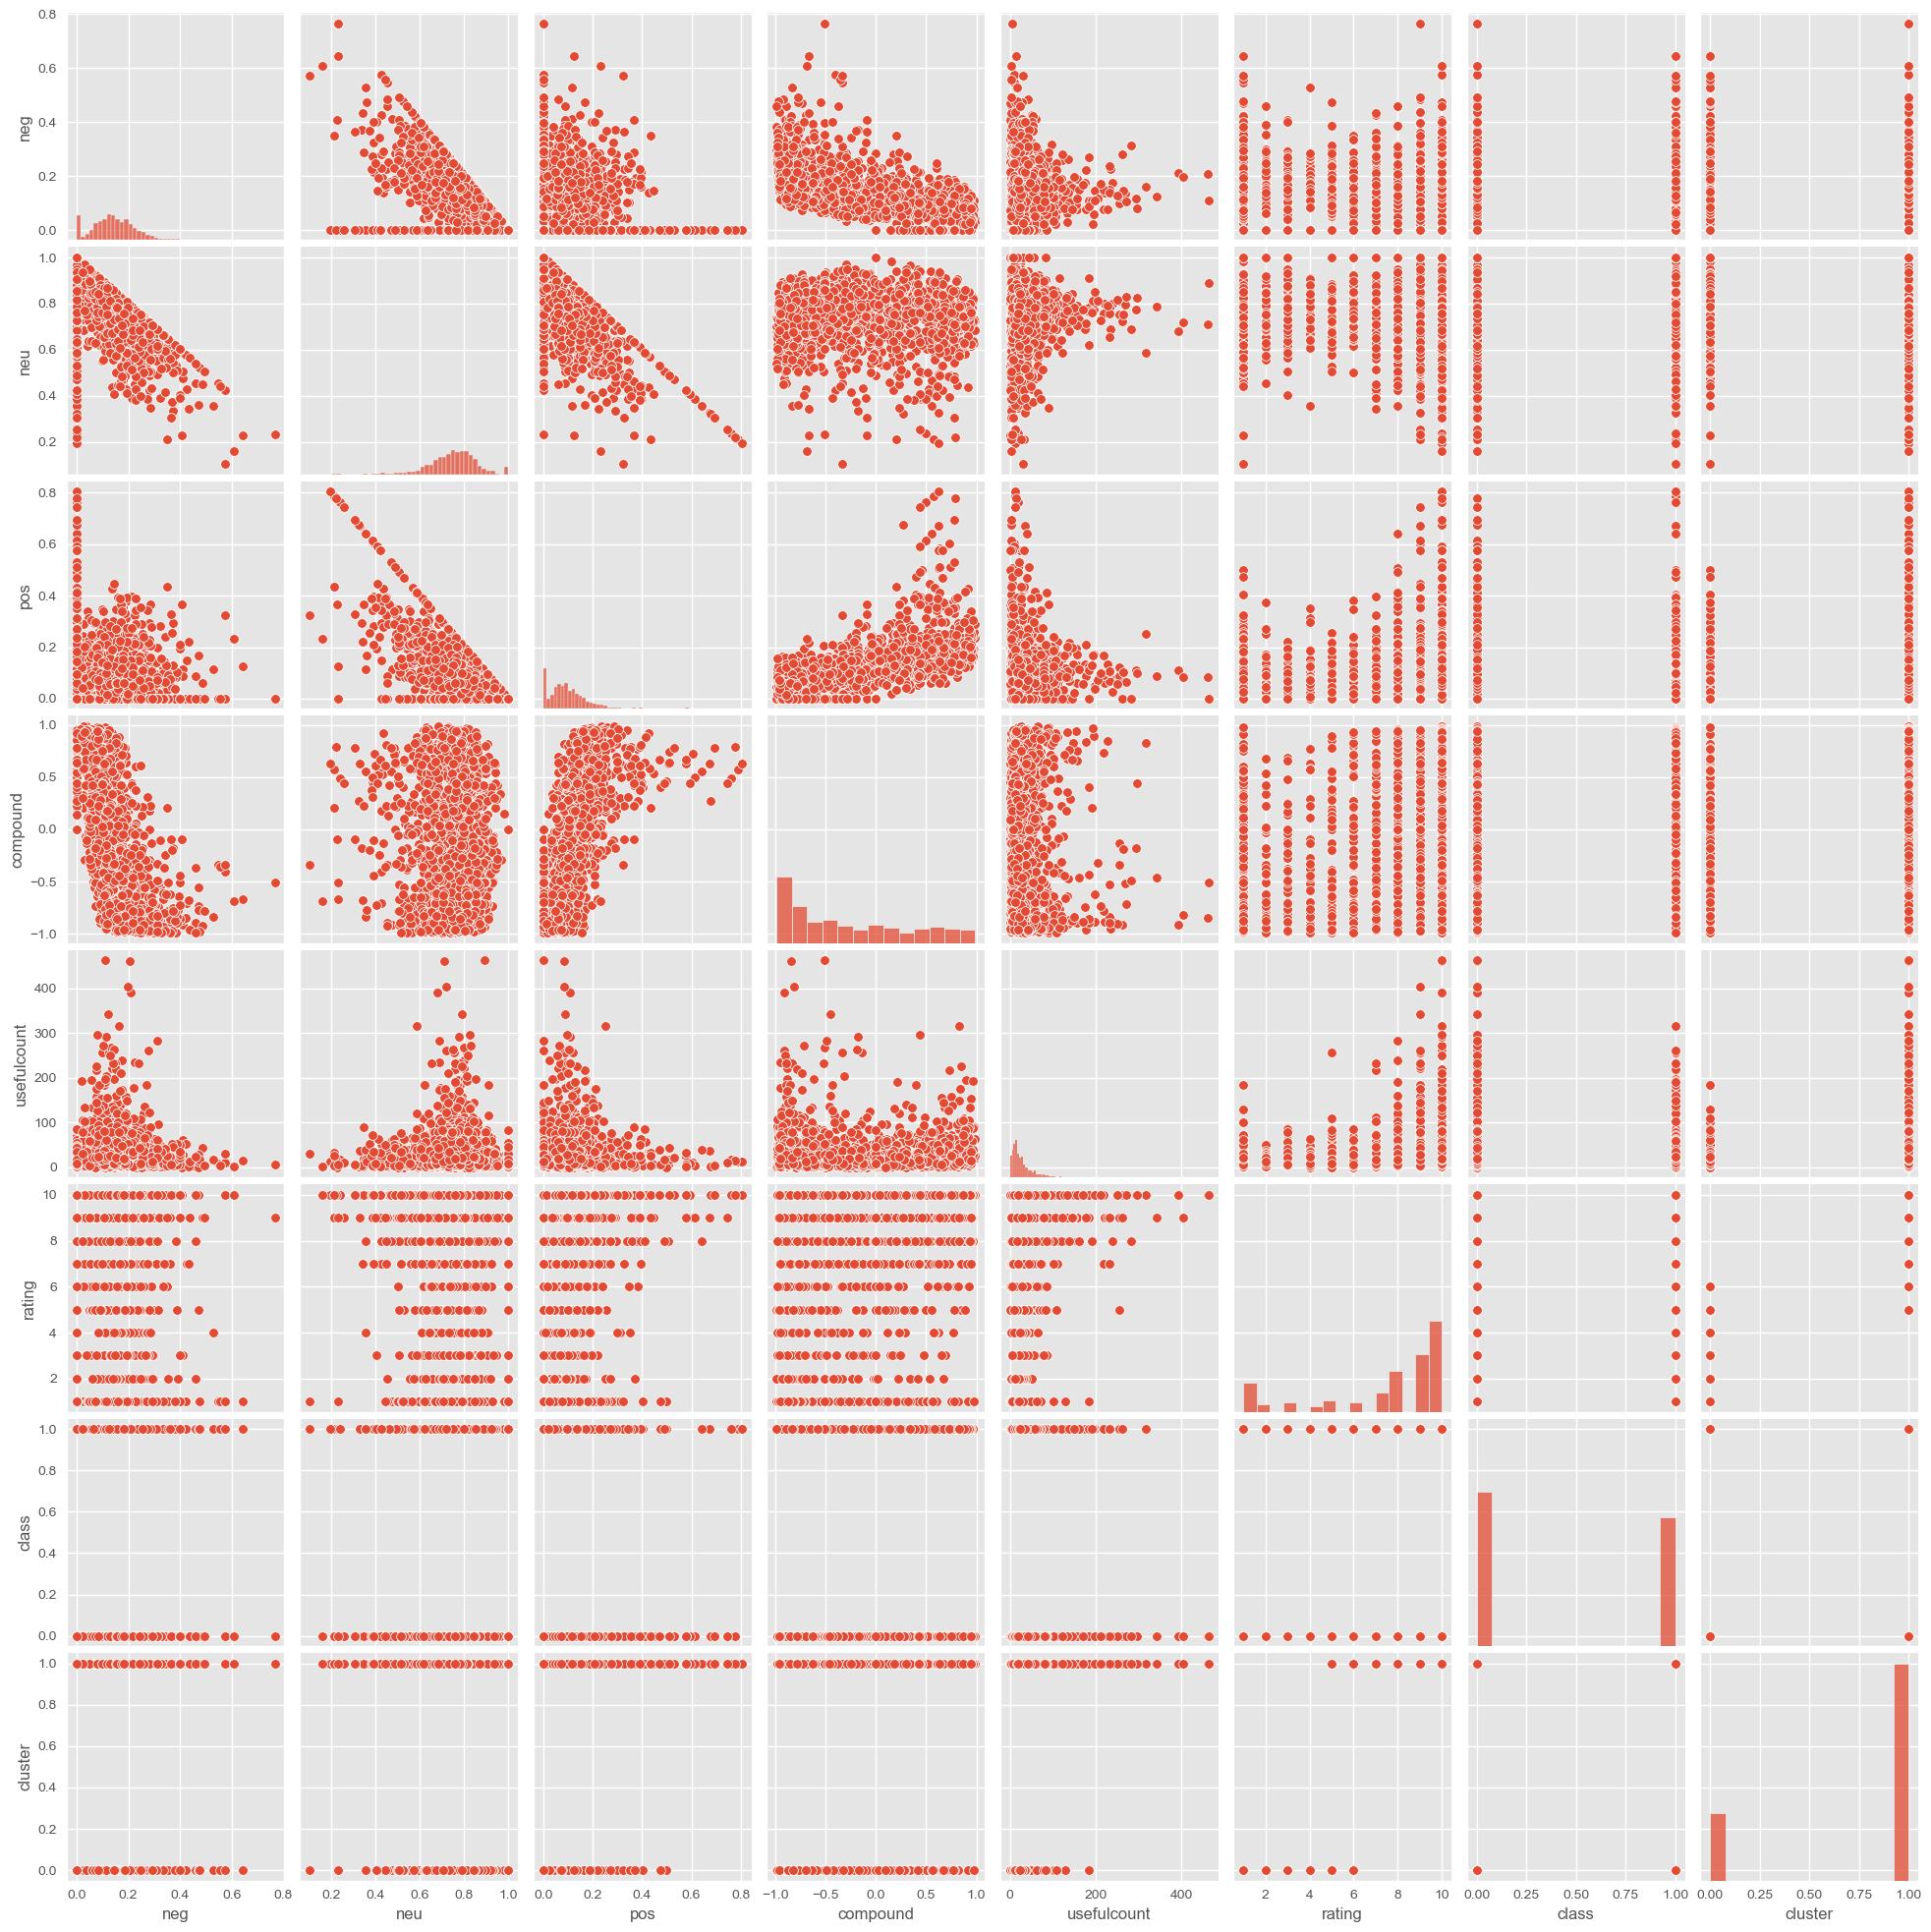

In [409]:
sns.pairplot(common_k2);

In [410]:
print(common_k2.groupby(['cluster']).mean())

              neg       neu       pos  compound  usefulcount    rating  \
cluster                                                                  
0        0.175562  0.746673  0.077782 -0.509839    22.107075  2.562141   
1        0.140607  0.743985  0.115423 -0.192741    36.289007  8.953901   

            class  
cluster            
0        0.701721  
1        0.378251  


One cluster has a rating of 2.56, and a moderately negative compound score. 

The other cluster has a higher mean rating of 8.95, and a less negative compound score. 

In [411]:
common_k2.cluster.value_counts(normalize = True)

1    0.763883
0    0.236117
Name: cluster, dtype: float64

In [412]:
silhouette_score(X, km.labels_)

0.37353141482826746

The score is above 0, so this model could provide information for those seeking it. 

I will use an elbow plot to determine the optimal k value.

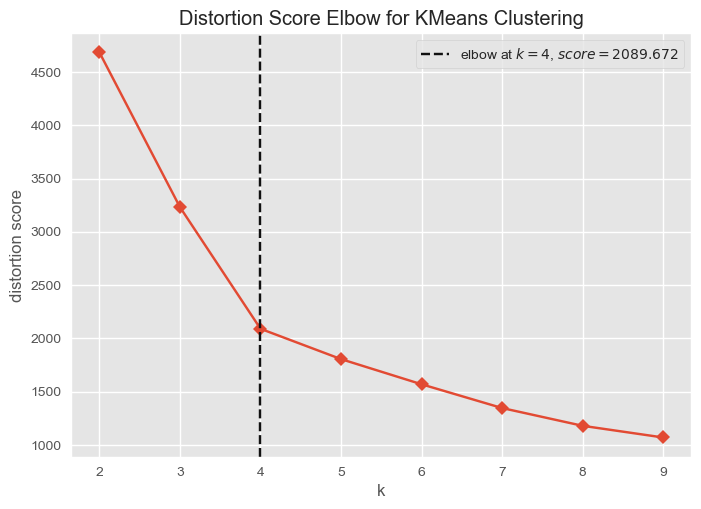

In [413]:
model = KMeans()

visualizer =  KElbowVisualizer(model, k=(2,10),timings=False)
visualizer.fit(X)
visualizer.show();


The optimal k value is 4. I will re-instantiate and see what is derived.

In [414]:
km = KMeans(n_clusters = 4, random_state = 6789) 
km.fit(X)

KMeans(n_clusters=4, random_state=6789)

In [415]:
km.cluster_centers_

array([[-0.41991978, -0.2660124 , -1.71681092],
       [-0.01352768,  3.88575655,  0.52116671],
       [-0.66801219, -0.11227002,  0.47868924],
       [ 1.18352664, -0.11550647,  0.44605802]])

In [416]:
common_k4 = common.copy()

common_k4['cluster'] = km.labels_
common_k4.head()

drug                                             review    neg    neu  \
235  Nucynta  "I have severe, constant pain following 4 seri...  0.136  0.814   
236  Nucynta  "This has worked great for me. Manages my pain...  0.140  0.698   
237  Nucynta  "I have severe IC. This is the only Med that m...  0.157  0.819   
238  Nucynta  "I have a form of muscular dystrophy and take ...  0.186  0.717   
239  Nucynta  "DO NOT TAKE THIS PILL...!!\r\nIF YOU HAVE ANY...  0.232  0.631   

       pos  compound  usefulcount  rating  class  cluster  
235  0.050   -0.7884           29     5.0    1.0        0  
236  0.163    0.0258           31     8.0    1.0        3  
237  0.024   -0.8271           22     8.0    1.0        2  
238  0.097   -0.8736           26    10.0    1.0        2  
239  0.138   -0.8894           33     1.0    1.0        0

In [417]:
ss.inverse_transform(km.cluster_centers_)

array([[ -0.52154873,  22.06751055,   2.28059072],
       [ -0.27579383, 191.7654321 ,   9.01234568],
       [ -0.67157608,  28.35152151,   8.88457503],
       [  0.44809321,  28.21923621,   8.7864215 ]])

In [418]:
## Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0           1         2
0 -0.521549   22.067511  2.280591
1 -0.275794  191.765432  9.012346
2 -0.671576   28.351522  8.884575
3  0.448093   28.219236  8.786421

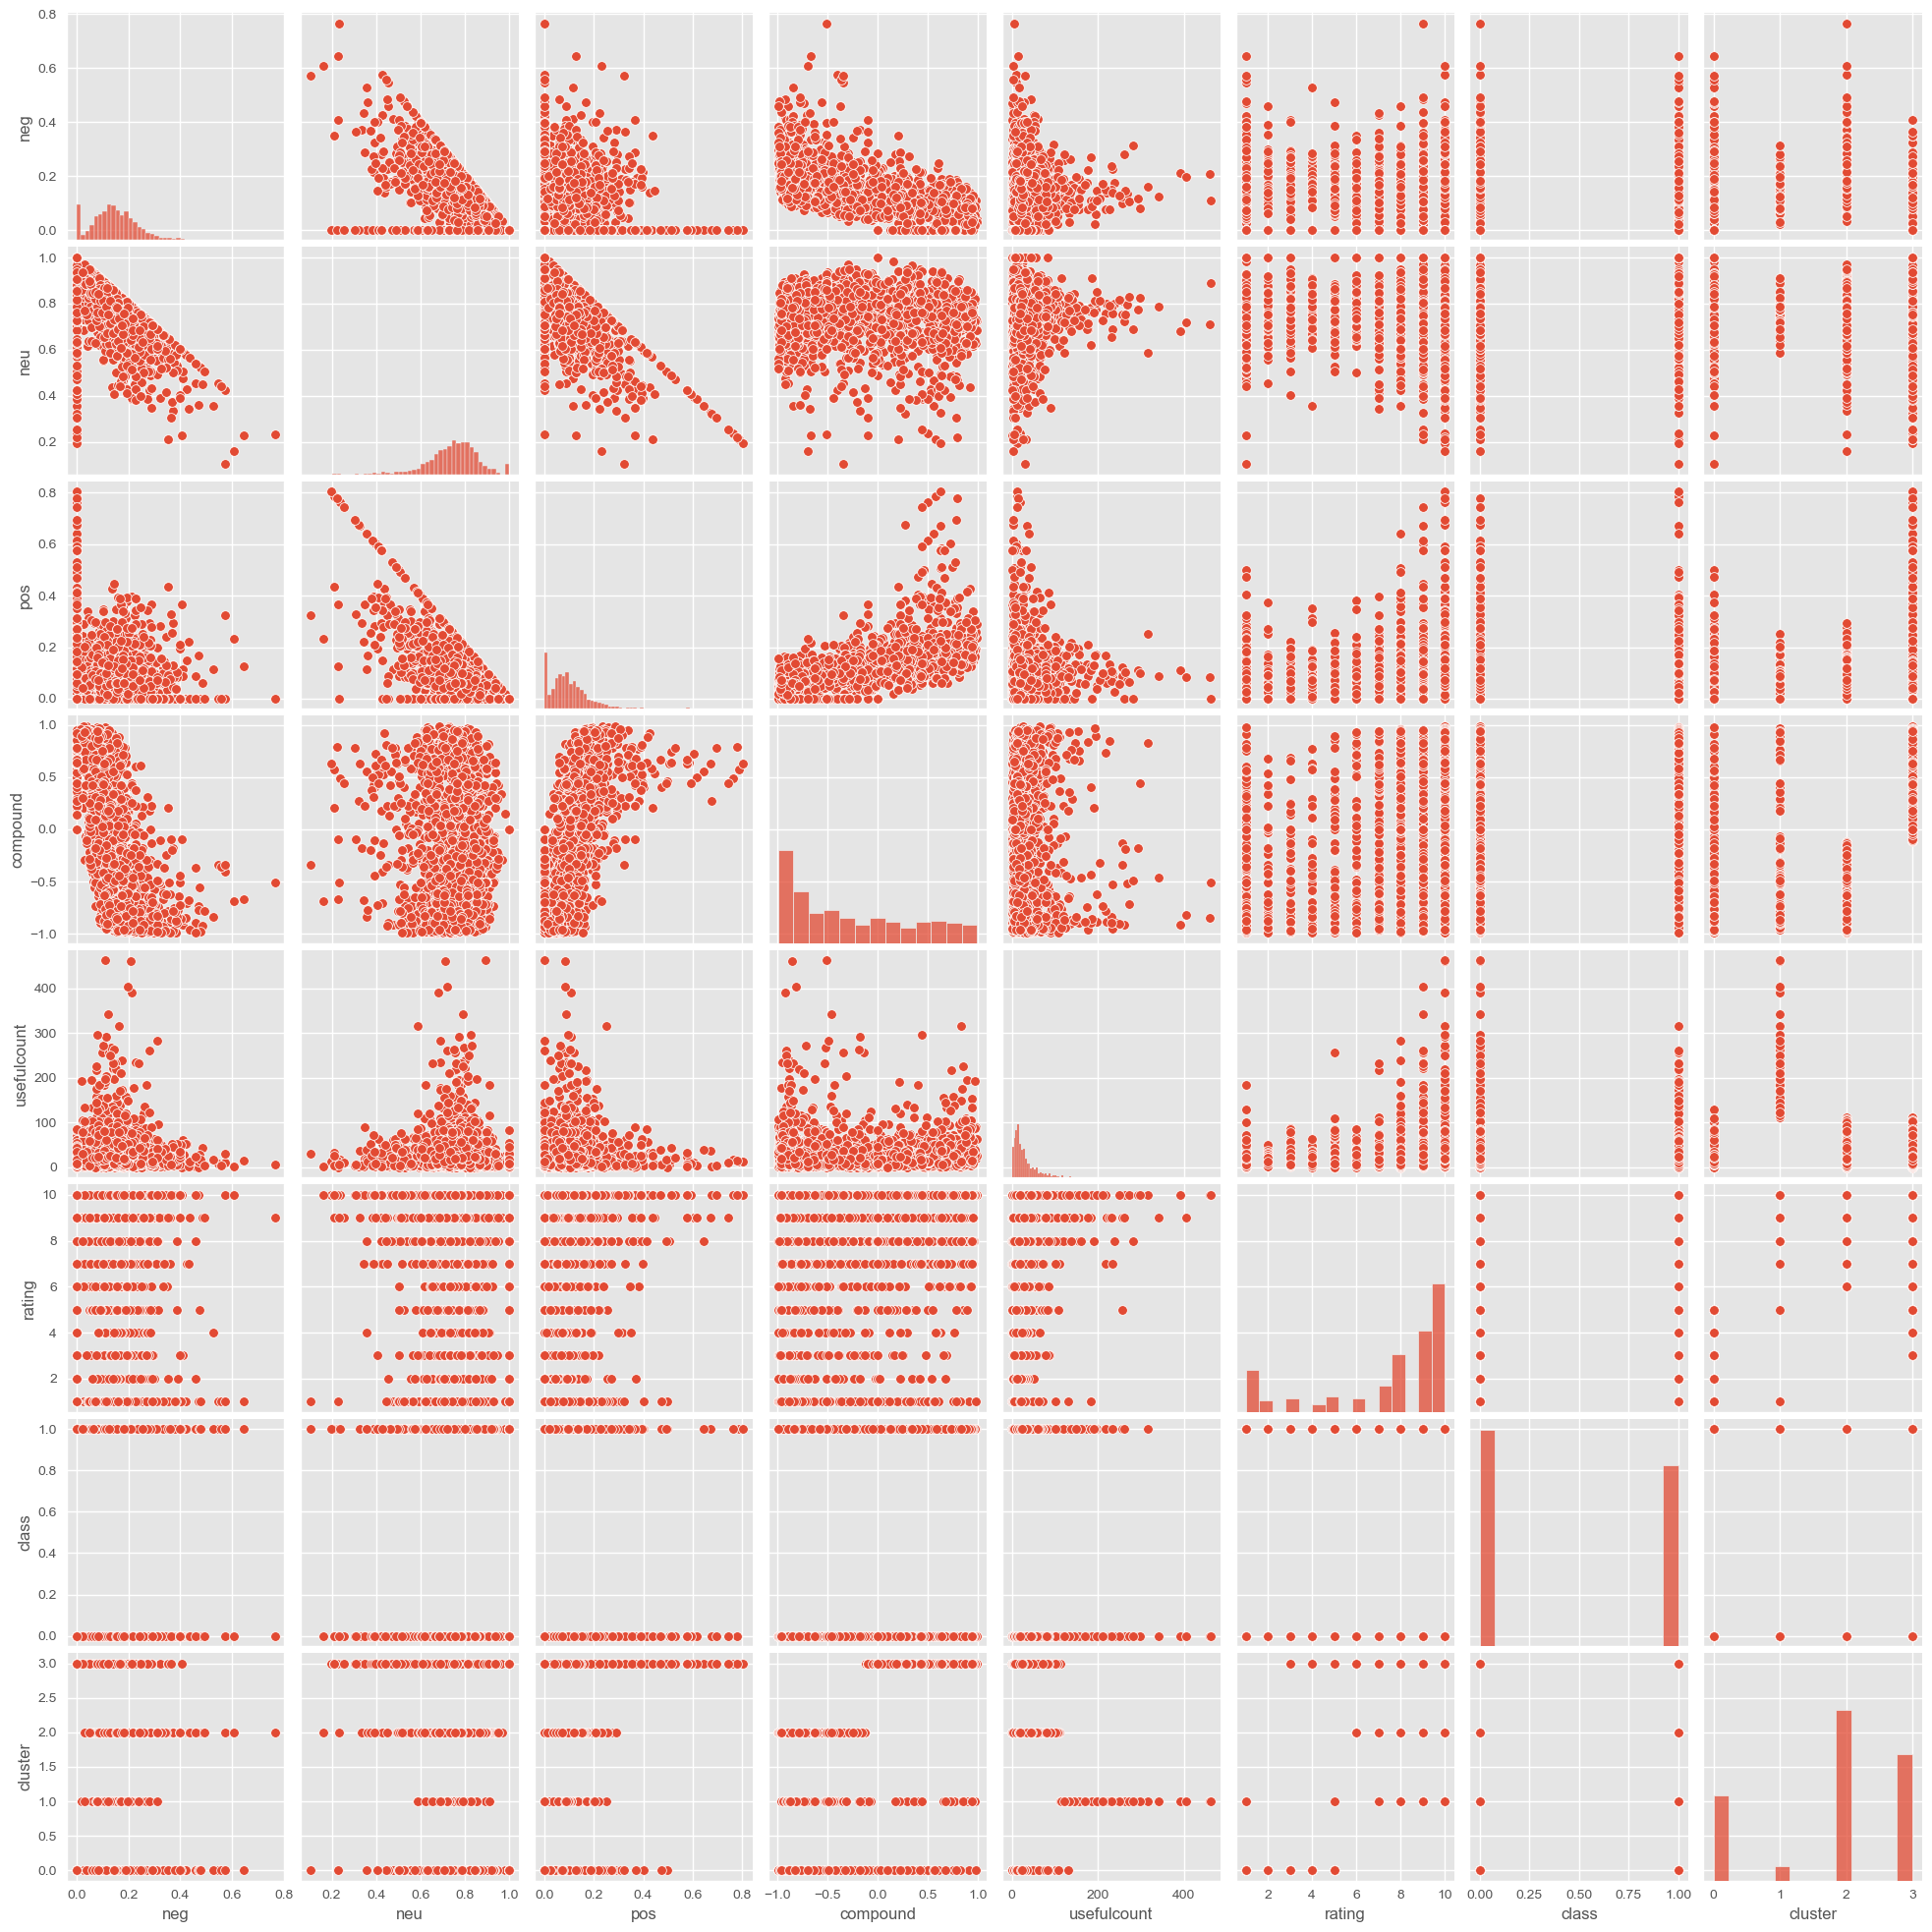

In [419]:
sns.pairplot(common_k4);

In [420]:
print(common_k4.groupby(['cluster']).mean())

              neg       neu       pos  compound  usefulcount    rating  \
cluster                                                                  
0        0.178705  0.744424  0.076882 -0.521549    22.067511  2.280591   
1        0.142235  0.758173  0.099568 -0.275794   191.765432  9.012346   
2        0.183864  0.745815  0.070347 -0.671576    28.351522  8.884575   
3        0.082429  0.741587  0.175994  0.448093    28.219236  8.786421   

            class  
cluster            
0        0.717300  
1        0.555556  
2        0.368311  
3        0.383310  


In [421]:
common_k4.cluster.value_counts(normalize = True)

2    0.430248
3    0.319187
0    0.213995
1    0.036569
Name: cluster, dtype: float64

Here, it can be seen that the cluster (0) with a rating of only 2.28 has a majority of One Common class members (average class closer to 1.) There is additionally a small cluster (1) with a very high useful count and very high ratings.

Additionally, clusters 2 and 3 have similar average ratings, useful count, and average class (closer to 0, 10 common,) but cluster 3 has a positive compound sentiment score, whereas cluster 2 has a negative compound score.

One could determine which drugs are represented at which values within each cluster, and potentially derive information.

I will determine the silhoutte score below.

In [422]:
silhouette_score(X, km.labels_)

0.4438049033762771

*Exclusion of rating from X value leads to silhoutte score of 0.481 (with optimal k value of 4), but with less distinction among the clusters for rating and class values. While the silhoutte score shown above is lower, the clusters may be more useful as the mean values for rating and class are more distinct.*

With a silhoutte score above 0, but it slightly less than 0.5, the structure of the clusters could be stronger, but analysis of them could still prove useful.

### Oxycodone & Tramadol

##### Pre-processing

In [423]:
oxytram.head()

drug                                             review    neg  \
707  Tramadol  "I was on 7.5/500 Hydrocodone 6-8 x daily for ...  0.238   
708  Tramadol  "I have rheumatoid arthritis, recently diagnos...  0.131   
709  Tramadol  "This is an exceptional drug for pain relief b...  0.226   
710  Tramadol  "I use Tramadol for chronic back pain. At time...  0.074   
711  Tramadol  "I DID NOT have a good experience with this me...  0.156   

       neu    pos  compound  usefulcount  rating  
707  0.686  0.076   -0.9773           36    10.0  
708  0.721  0.147    0.1280           16     8.0  
709  0.566  0.208   -0.2500           23     3.0  
710  0.856  0.070   -0.0516            8     8.0  
711  0.746  0.098   -0.7169           11     1.0

In [424]:
oxytram_k = oxytram.set_index('drug')

oxytram_k.head()

review    neg    neu  \
drug                                                                        
Tramadol  "I was on 7.5/500 Hydrocodone 6-8 x daily for ...  0.238  0.686   
Tramadol  "I have rheumatoid arthritis, recently diagnos...  0.131  0.721   
Tramadol  "This is an exceptional drug for pain relief b...  0.226  0.566   
Tramadol  "I use Tramadol for chronic back pain. At time...  0.074  0.856   
Tramadol  "I DID NOT have a good experience with this me...  0.156  0.746   

            pos  compound  usefulcount  rating  
drug                                            
Tramadol  0.076   -0.9773           36    10.0  
Tramadol  0.147    0.1280           16     8.0  
Tramadol  0.208   -0.2500           23     3.0  
Tramadol  0.070   -0.0516            8     8.0  
Tramadol  0.098   -0.7169           11     1.0

In [425]:
oxytram_k = oxytram_k.drop(columns = ['review'])

oxytram_k.head()

neg    neu    pos  compound  usefulcount  rating
drug                                                        
Tramadol  0.238  0.686  0.076   -0.9773           36    10.0
Tramadol  0.131  0.721  0.147    0.1280           16     8.0
Tramadol  0.226  0.566  0.208   -0.2500           23     3.0
Tramadol  0.074  0.856  0.070   -0.0516            8     8.0
Tramadol  0.156  0.746  0.098   -0.7169           11     1.0

##### Create X and scale features

In [516]:
X = oxytram_k[['compound', 'usefulcount', 'rating']]

ss = StandardScaler()

X = ss.fit_transform(X)

In [517]:
km = KMeans(n_clusters = 2, random_state = 6789) 
km.fit(X)

KMeans(n_clusters=2, random_state=6789)

In [518]:
km.cluster_centers_

array([[ 0.11441139,  0.09359712,  0.47887174],
       [-0.41072865, -0.33600692, -1.71911509]])

In [519]:
oxytram_k2 = oxytram_k.copy()

oxytram_k2['cluster'] = km.labels_
oxytram_k2.head()

neg    neu    pos  compound  usefulcount  rating  cluster
drug                                                                 
Tramadol  0.238  0.686  0.076   -0.9773           36    10.0        0
Tramadol  0.131  0.721  0.147    0.1280           16     8.0        0
Tramadol  0.226  0.566  0.208   -0.2500           23     3.0        1
Tramadol  0.074  0.856  0.070   -0.0516            8     8.0        0
Tramadol  0.156  0.746  0.098   -0.7169           11     1.0        1

In [520]:
ss.inverse_transform(km.cluster_centers_)

array([[-0.16892986, 40.46693387,  8.96392786],
       [-0.49130288, 17.90647482,  2.44604317]])

In [521]:
centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0          1         2
0 -0.168930  40.466934  8.963928
1 -0.491303  17.906475  2.446043

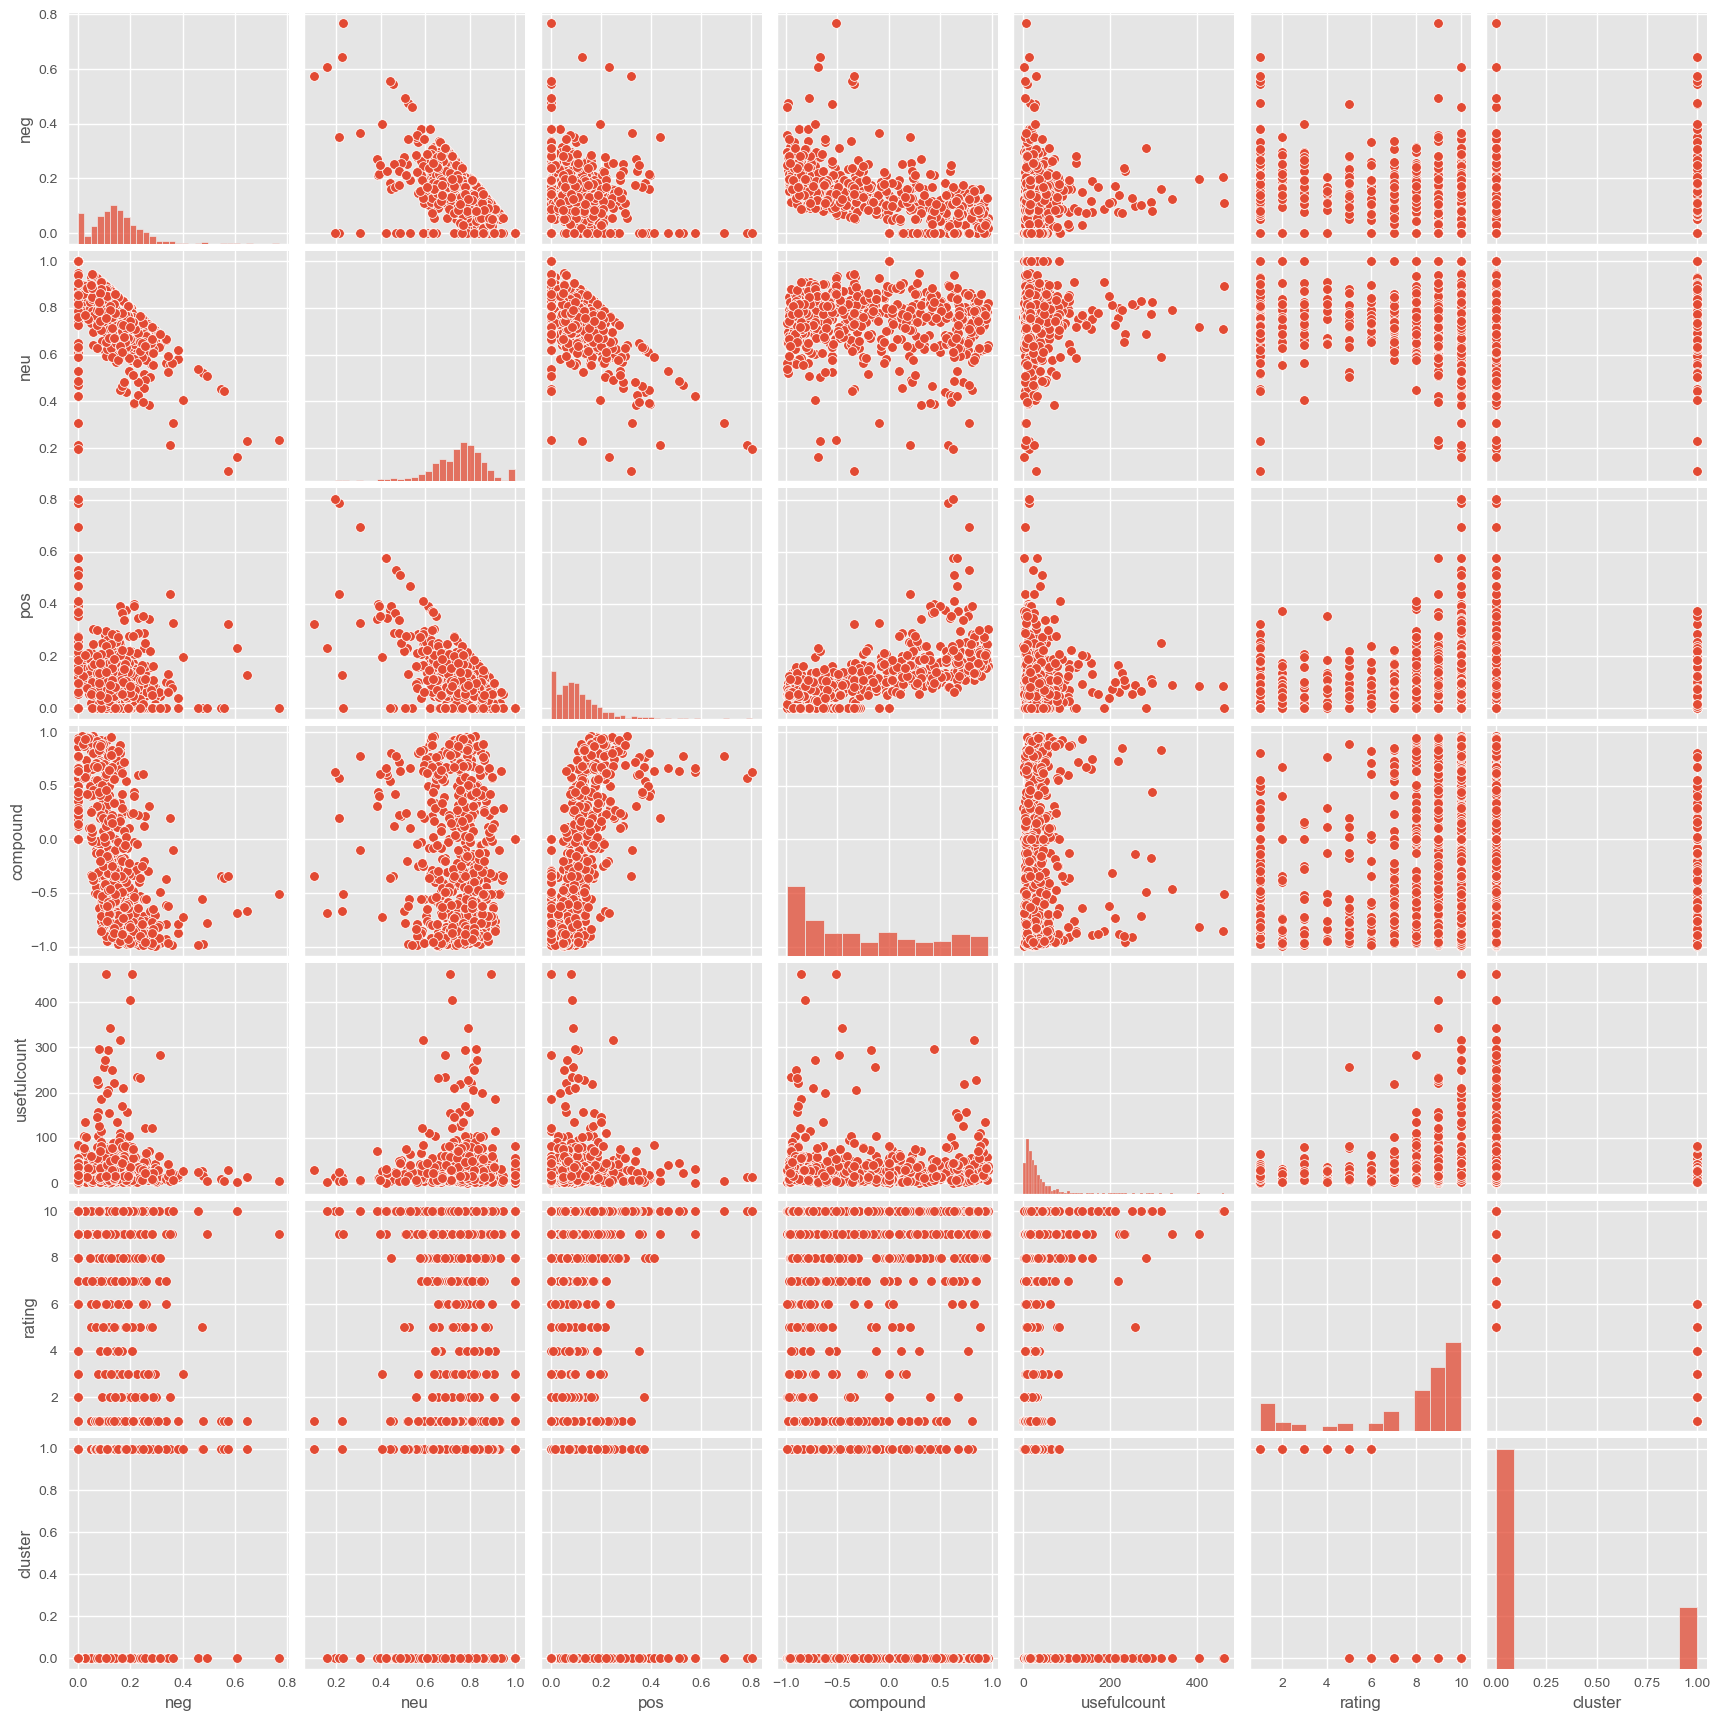

In [522]:
sns.pairplot(oxytram_k2);

In [523]:
print(oxytram_k2.groupby(['cluster']).mean())

              neg       neu       pos  compound  usefulcount    rating
cluster                                                               
0        0.136625  0.746411  0.116998 -0.168930    40.466934  8.963928
1        0.181439  0.738504  0.080072 -0.491303    17.906475  2.446043


In [524]:
oxytram_k2.cluster.value_counts(normalize = True)

0    0.782132
1    0.217868
Name: cluster, dtype: float64

In [525]:
oxytram_k2.head()

neg    neu    pos  compound  usefulcount  rating  cluster
drug                                                                 
Tramadol  0.238  0.686  0.076   -0.9773           36    10.0        0
Tramadol  0.131  0.721  0.147    0.1280           16     8.0        0
Tramadol  0.226  0.566  0.208   -0.2500           23     3.0        1
Tramadol  0.074  0.856  0.070   -0.0516            8     8.0        0
Tramadol  0.156  0.746  0.098   -0.7169           11     1.0        1

In [526]:
silhouette_score(X, km.labels_)

0.39392922963480614

With a silhoutte score above 0, this model could be used. For example, Cluster 0 has a high average rating, less negative compound score, and higher average useful count. Cluster 1 has a low average rating, more negative compound score, and lower useful count.

I will see what an elbow plot determines the optimal k value to be.

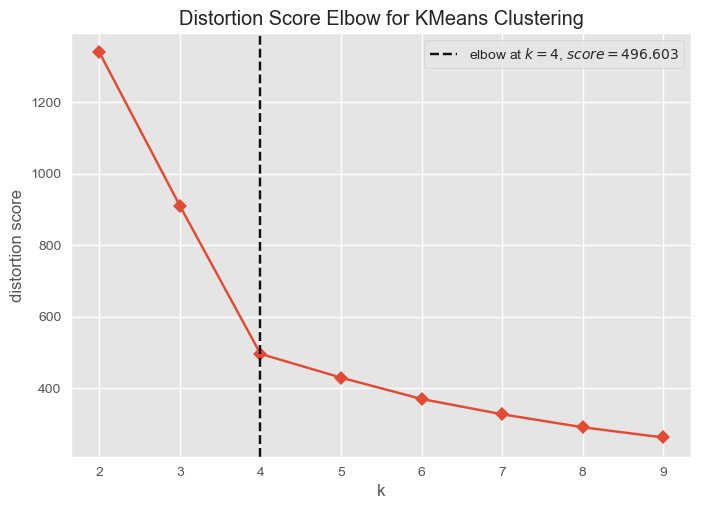

In [527]:
model = KMeans()

visualizer =  KElbowVisualizer(model, k=(2,10),timings=False)
visualizer.fit(X)
visualizer.show();

##### Re-fit & Instantiate

In [528]:
km = KMeans(n_clusters = 4, random_state = 6789) 
km.fit(X)

KMeans(n_clusters=4, random_state=6789)

In [529]:
km.cluster_centers_

array([[-0.71778963, -0.11724347,  0.43145145],
       [-0.39973342, -0.33139938, -1.81420573],
       [ 1.11993339, -0.10743337,  0.47280781],
       [-0.29669518,  4.4298224 ,  0.56767794]])

In [530]:
oxytram_k4 = oxytram_k.copy()

oxytram_k4['cluster'] = km.labels_
oxytram_k4.head()

neg    neu    pos  compound  usefulcount  rating  cluster
drug                                                                 
Tramadol  0.238  0.686  0.076   -0.9773           36    10.0        0
Tramadol  0.131  0.721  0.147    0.1280           16     8.0        2
Tramadol  0.226  0.566  0.208   -0.2500           23     3.0        1
Tramadol  0.074  0.856  0.070   -0.0516            8     8.0        2
Tramadol  0.156  0.746  0.098   -0.7169           11     1.0        1

In [531]:
ss.inverse_transform(km.cluster_centers_)

array([[ -0.6798015 ,  29.39473684,   8.82330827],
       [ -0.48455312,  18.1484375 ,   2.1640625 ],
       [  0.44834009,  29.90990991,   8.94594595],
       [ -0.4213    , 268.18181818,   9.22727273]])

In [532]:
## Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0           1         2
0 -0.679802   29.394737  8.823308
1 -0.484553   18.148438  2.164062
2  0.448340   29.909910  8.945946
3 -0.421300  268.181818  9.227273

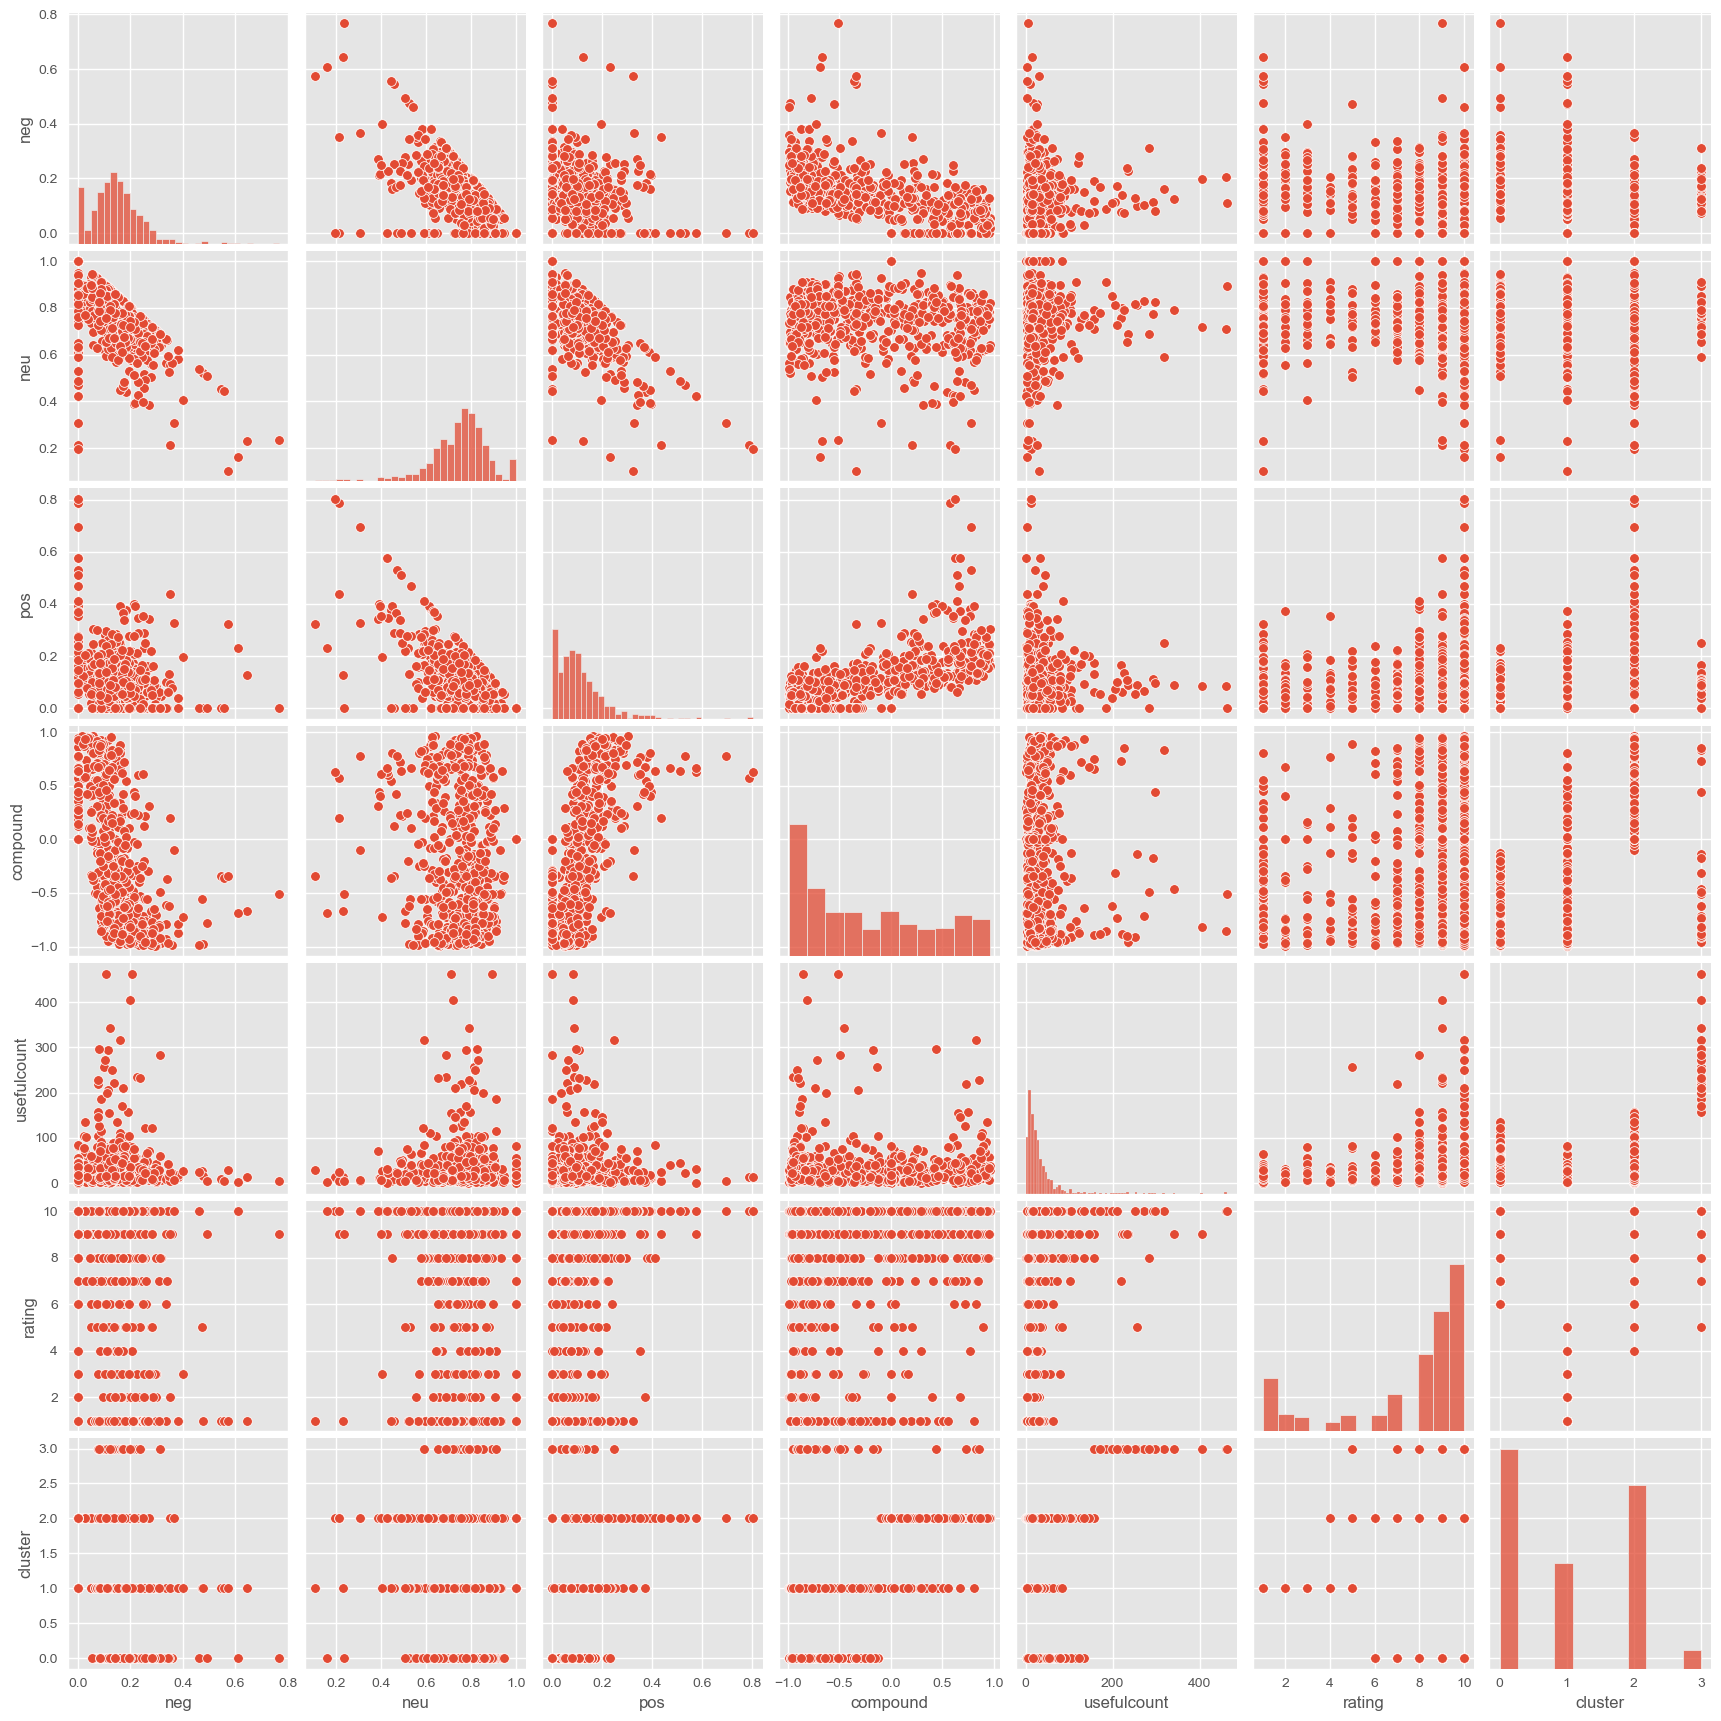

In [533]:
sns.pairplot(oxytram_k4);

In [534]:
print(oxytram_k4.groupby(['cluster']).mean())

              neg       neu       pos  compound  usefulcount    rating
cluster                                                               
0        0.181707  0.750628  0.067722 -0.679802    29.394737  8.823308
1        0.182508  0.737844  0.079664 -0.484553    18.148438  2.164062
2        0.083171  0.738910  0.177923  0.448340    29.909910  8.945946
3        0.147136  0.771000  0.081909 -0.421300   268.181818  9.227273


In [535]:
oxytram_k4.cluster.value_counts(normalize = True)

0    0.416928
2    0.347962
1    0.200627
3    0.034483
Name: cluster, dtype: float64

Here, there is 1 small cluster with a very high useful count and rating. Two clusters have similar sentiment scores, but very low useful counts and ratings. It could be worthwhile to compare these two groups.

I will observe the silhoutte score below.

In [536]:
silhouette_score(X, km.labels_)

0.47685568694236424

This score is higher than the 2 cluster model, and could potentially provide more information by means of more comparisons between groups. While the silhoutte score is above 0, it is slightly less than 0.5. The structure of the clusters could be stronger, but analysis of them could still prove beneficial.

### Pain - Full Dataset

What information could be derived by clustering ALL reviews for the pain condition? I will explore this below.

In [447]:
pain.head()

drug                                             review    neg  \
0     Ibudone  "I just started taking this medicine.  I have ...  0.203   
1  Ultram ODT  "You can use ultram to detox yourself from har...  0.081   
2  Ultram ODT  "I have been using tramadol for eight years fo...  0.195   
3     Belbuca  "I was on Fentynal  patches for year and a hal...  0.092   
4     Talacen  "I have rheumatoid arthritis and a few other b...  0.125   

     neu    pos  compound  usefulcount  rating  
0  0.797  0.000   -0.9633           27     7.0  
1  0.741  0.178    0.4939           28    10.0  
2  0.777  0.028   -0.9141          105    10.0  
3  0.834  0.075   -0.2298           14     1.0  
4  0.821  0.054   -0.5093           12     9.0

In [448]:
pain.shape

(6145, 8)

##### Pre-processing

In [449]:
pain_k = pain.set_index('drug')

pain_k.head()

review    neg    neu  \
drug                                                                          
Ibudone     "I just started taking this medicine.  I have ...  0.203  0.797   
Ultram ODT  "You can use ultram to detox yourself from har...  0.081  0.741   
Ultram ODT  "I have been using tramadol for eight years fo...  0.195  0.777   
Belbuca     "I was on Fentynal  patches for year and a hal...  0.092  0.834   
Talacen     "I have rheumatoid arthritis and a few other b...  0.125  0.821   

              pos  compound  usefulcount  rating  
drug                                              
Ibudone     0.000   -0.9633           27     7.0  
Ultram ODT  0.178    0.4939           28    10.0  
Ultram ODT  0.028   -0.9141          105    10.0  
Belbuca     0.075   -0.2298           14     1.0  
Talacen     0.054   -0.5093           12     9.0

In [450]:
pain_k = pain_k.drop(columns = ['review'])

pain_k.head()

neg    neu    pos  compound  usefulcount  rating
drug                                                          
Ibudone     0.203  0.797  0.000   -0.9633           27     7.0
Ultram ODT  0.081  0.741  0.178    0.4939           28    10.0
Ultram ODT  0.195  0.777  0.028   -0.9141          105    10.0
Belbuca     0.092  0.834  0.075   -0.2298           14     1.0
Talacen     0.125  0.821  0.054   -0.5093           12     9.0

In [451]:
pain_k.shape

(6145, 6)

##### Create X and scale features

In [452]:
X = pain_k[['compound', 'usefulcount', 'rating']]

ss = StandardScaler()

X = ss.fit_transform(X)

In [453]:
km = KMeans(n_clusters = 2, random_state = 6789) 
km.fit(X)

KMeans(n_clusters=2, random_state=6789)

In [454]:
km.cluster_centers_

array([[-0.39842254, -0.32884397, -1.74066142],
       [ 0.10742591,  0.08866557,  0.46933123]])

In [455]:
pain_k2 = pain_k.copy()

pain_k2['cluster'] = km.labels_
pain_k2.head()

neg    neu    pos  compound  usefulcount  rating  cluster
drug                                                                   
Ibudone     0.203  0.797  0.000   -0.9633           27     7.0        1
Ultram ODT  0.081  0.741  0.178    0.4939           28    10.0        1
Ultram ODT  0.195  0.777  0.028   -0.9141          105    10.0        1
Belbuca     0.092  0.834  0.075   -0.2298           14     1.0        0
Talacen     0.125  0.821  0.054   -0.5093           12     9.0        1

In [456]:
ss.inverse_transform(km.cluster_centers_)

array([[-0.49118743, 21.78007663,  2.53563218],
       [-0.17985659, 39.29380165,  9.00640496]])

In [457]:
centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0          1         2
0 -0.491187  21.780077  2.535632
1 -0.179857  39.293802  9.006405

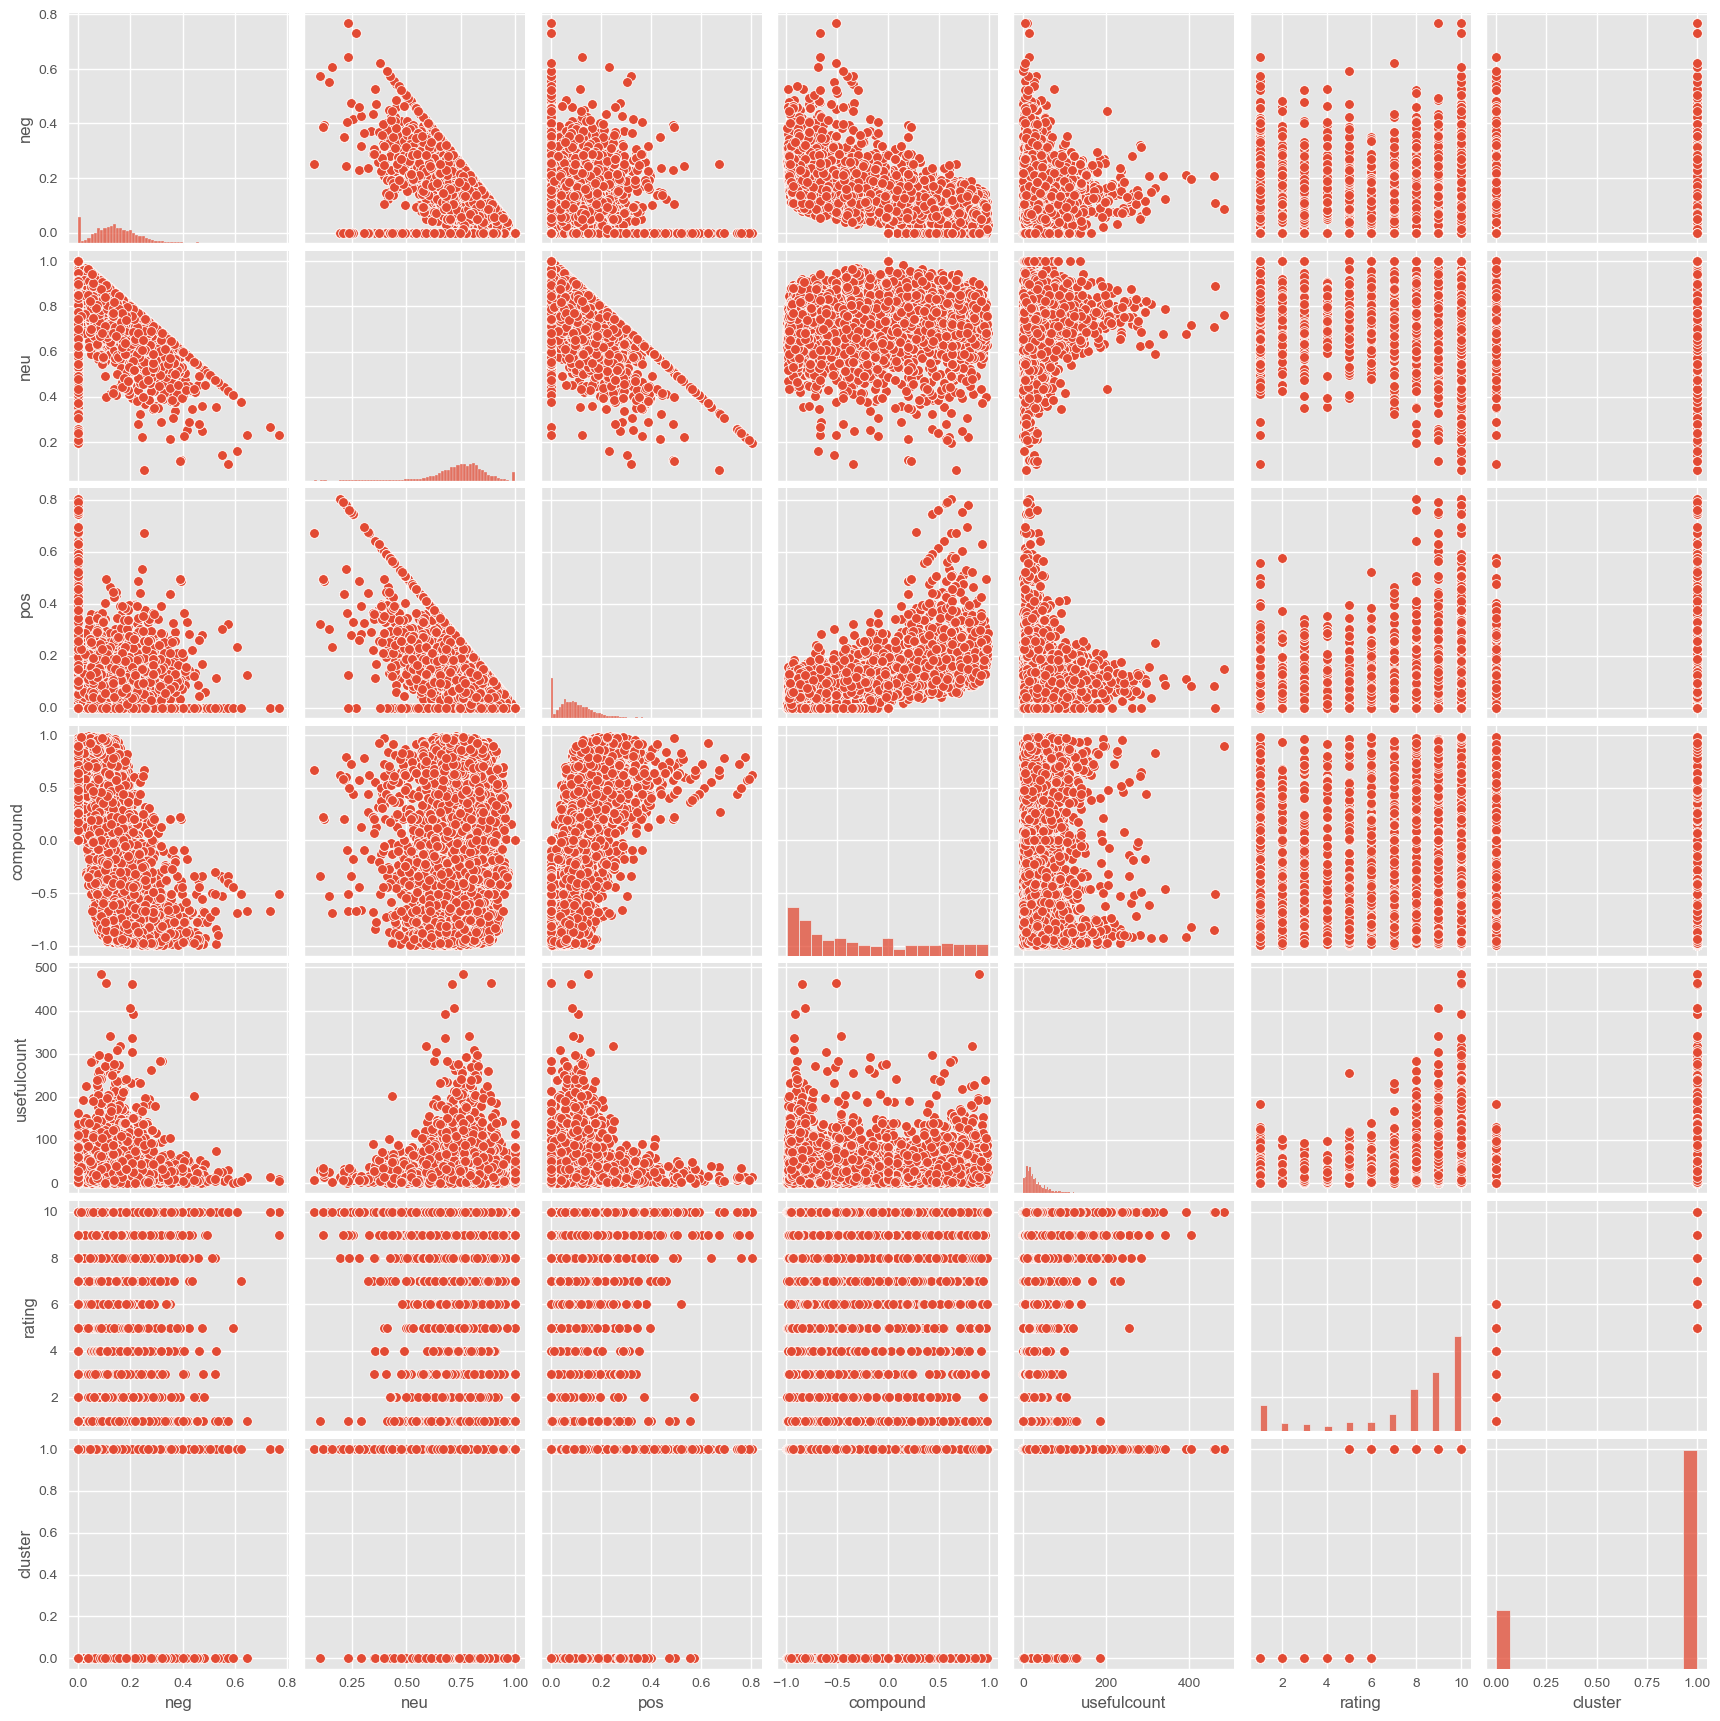

In [458]:
sns.pairplot(pain_k2);

In [459]:
print(pain_k2.groupby(['cluster']).mean())

              neg       neu      pos  compound  usefulcount    rating
cluster                                                              
0        0.173116  0.750817  0.07609 -0.491187    21.780077  2.535632
1        0.138458  0.746632  0.11492 -0.179857    39.293802  9.006405


In [460]:
pain_k2.cluster.value_counts(normalize = True)

1    0.787632
0    0.212368
Name: cluster, dtype: float64

One cluster has a low rating of 2.54, a lower useful count, and a more negative compound score.

The other cluster has a high rating of 9.00, a higher useful count, and a less negative compound score.

It seems this could be used to generally compare information between reviews from patients who are highly satisfied or dissatisfied with their pain medication. I will determine the silhoutte score below.

In [461]:
silhouette_score(X, km.labels_)

0.38416130532054105

I will determine the optimal k value below.

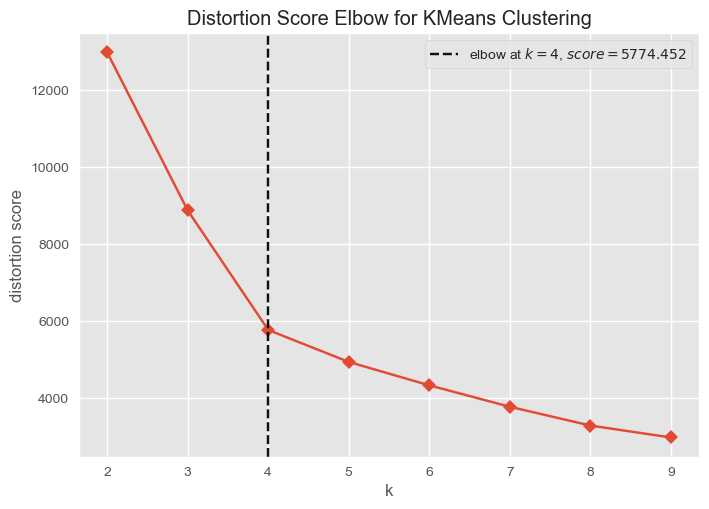

In [462]:
model = KMeans()

visualizer =  KElbowVisualizer(model, k=(2,10),timings=False)
visualizer.fit(X)
visualizer.show();


##### Re-fit & Instantiate

In [463]:
km = KMeans(n_clusters = 4, random_state = 6789) 
km.fit(X)

KMeans(n_clusters=4, random_state=6789)

In [464]:
km.cluster_centers_

array([[-0.70008251, -0.12187134,  0.44416704],
       [-0.01625026,  3.36736044,  0.47533119],
       [ 1.14621275, -0.13217505,  0.43007145],
       [-0.41064672, -0.33180215, -1.84066245]])

In [465]:
pain_k4 = pain_k.copy()

pain_k4['cluster'] = km.labels_
pain_k4.head()

neg    neu    pos  compound  usefulcount  rating  cluster
drug                                                                   
Ibudone     0.203  0.797  0.000   -0.9633           27     7.0        0
Ultram ODT  0.081  0.741  0.178    0.4939           28    10.0        2
Ultram ODT  0.195  0.777  0.028   -0.9141          105    10.0        0
Belbuca     0.092  0.834  0.075   -0.2298           14     1.0        3
Talacen     0.125  0.821  0.054   -0.5093           12     9.0        0

In [466]:
ss.inverse_transform(km.cluster_centers_)

array([[ -0.67684789,  30.46218168,   8.9327252 ],
       [ -0.25597466, 176.82876712,   9.0239726 ],
       [  0.45947795,  30.02996071,   8.89145383],
       [ -0.49871096,  21.65598651,   2.24283305]])

In [467]:
centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0           1         2
0 -0.676848   30.462182  8.932725
1 -0.255975  176.828767  9.023973
2  0.459478   30.029961  8.891454
3 -0.498711   21.655987  2.242833

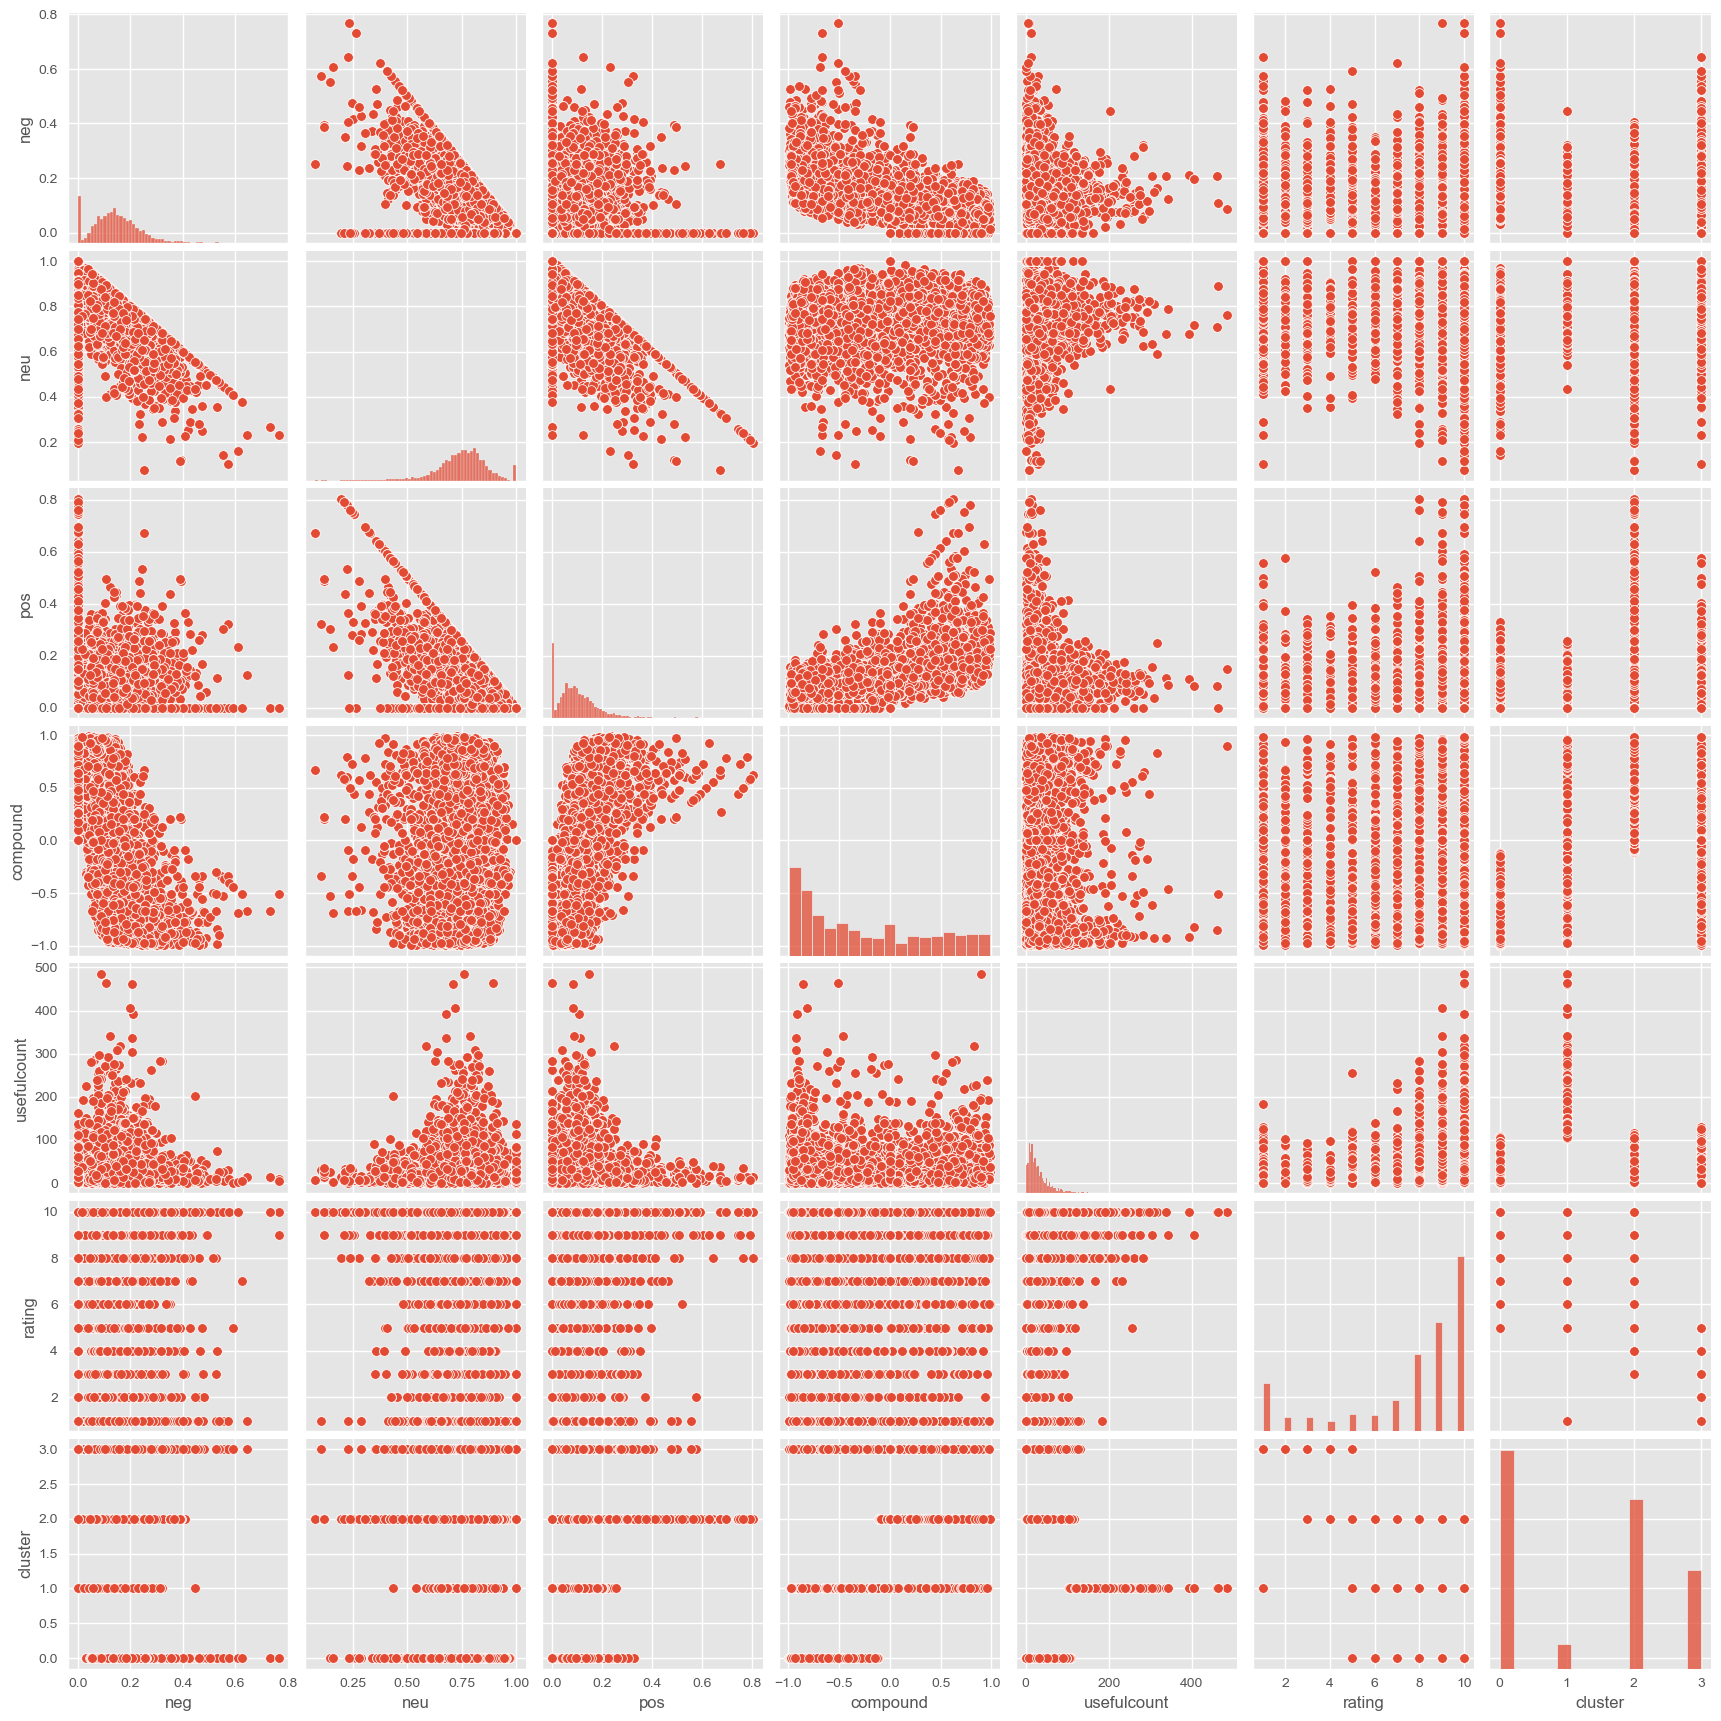

In [468]:
sns.pairplot(pain_k4);

In [469]:
print(pain_k4.groupby(['cluster']).mean())

              neg       neu       pos  compound  usefulcount    rating
cluster                                                               
0        0.182707  0.747744  0.069568 -0.676693    30.488982  8.932751
1        0.143093  0.756292  0.100619 -0.255930   177.089347  9.024055
2        0.081245  0.744840  0.173918  0.459478    30.029961  8.891454
3        0.175476  0.749473  0.075068 -0.498711    21.655987  2.242833


In [470]:
pain_k4.cluster.value_counts(normalize = True)

0    0.428316
2    0.331326
3    0.193002
1    0.047356
Name: cluster, dtype: float64

In [471]:
silhouette_score(X, km.labels_)

0.4451566906477798

The silhoutte score is above zero, but slightly less than 0.5, so the clusters could be more strongly-defined. 

However, the clusters as created with distinct comibinations of mean compound sentiment score, useful count, and rating, the clusters could provide information that could be useful. 

### Reviews - Full Dataset

I will bring my study full circle by returning to the full datset for clustering. Although I have little information regarding conditions other than pain, it may still be of use to see how the reviews could be clustered.

I will use the rating and useful count to create clusters.

In [472]:
reviews.head()

drug                  condition  \
0  Medroxyprogesterone                 Amenorrhea   
1  Medroxyprogesterone  Abnormal Uterine Bleeding   
2  Medroxyprogesterone              Birth Control   
3  Medroxyprogesterone  Abnormal Uterine Bleeding   
4  Medroxyprogesterone  Abnormal Uterine Bleeding   

                                              review  rating  usefulcount  
0  "I&#039;m 21 years old and recently found out ...    10.0           11  
1  "I have been on the shot 11 years and until a ...     8.0            7  
2  "Ive had four shots at this point. I was on bi...     9.0           12  
3  "I had a total of 3 shots. I got my first one ...     1.0            4  
4  "I&#039;m 18 and got this for heavy bleeding. ...     5.0            6

##### Pre-processing

In [473]:
reviews_k = reviews.set_index('drug')

reviews_k.head()

condition  \
drug                                             
Medroxyprogesterone                 Amenorrhea   
Medroxyprogesterone  Abnormal Uterine Bleeding   
Medroxyprogesterone              Birth Control   
Medroxyprogesterone  Abnormal Uterine Bleeding   
Medroxyprogesterone  Abnormal Uterine Bleeding   

                                                                review  \
drug                                                                     
Medroxyprogesterone  "I&#039;m 21 years old and recently found out ...   
Medroxyprogesterone  "I have been on the shot 11 years and until a ...   
Medroxyprogesterone  "Ive had four shots at this point. I was on bi...   
Medroxyprogesterone  "I had a total of 3 shots. I got my first one ...   
Medroxyprogesterone  "I&#039;m 18 and got this for heavy bleeding. ...   

                     rating  usefulcount  
drug                                      
Medroxyprogesterone    10.0           11  
Medroxyprogesterone     8.0            7  
Medroxyprogesterone     9.0           12  
Medroxyprogesterone     1.0            4  
Medroxyprogesterone     5.0            6

In [474]:
reviews_k = reviews_k.drop(columns = ['condition', 'review'])

reviews_k.head()

rating  usefulcount
drug                                    
Medroxyprogesterone    10.0           11
Medroxyprogesterone     8.0            7
Medroxyprogesterone     9.0           12
Medroxyprogesterone     1.0            4
Medroxyprogesterone     5.0            6

In [475]:
X = reviews_k[['rating', 'usefulcount']]

ss = StandardScaler()

X = ss.fit_transform(X)

In [476]:
km = KMeans(n_clusters = 2, random_state = 6789) 
km.fit(X)

KMeans(n_clusters=2, random_state=6789)

In [477]:
km.cluster_centers_

array([[-1.32686677, -0.37118798],
       [ 0.62353584,  0.17443274]])

In [478]:
reviews_k2 = reviews_k.copy()

reviews_k2['cluster'] = km.labels_
reviews_k2.head()

rating  usefulcount  cluster
drug                                             
Medroxyprogesterone    10.0           11        1
Medroxyprogesterone     8.0            7        1
Medroxyprogesterone     9.0           12        1
Medroxyprogesterone     1.0            4        0
Medroxyprogesterone     5.0            6        0

In [479]:
ss.inverse_transform(km.cluster_centers_)

array([[ 2.65244541, 14.49216538],
       [ 9.03478507, 34.35474023]])

In [480]:
centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0          1
0  2.652445  14.492165
1  9.034785  34.354740

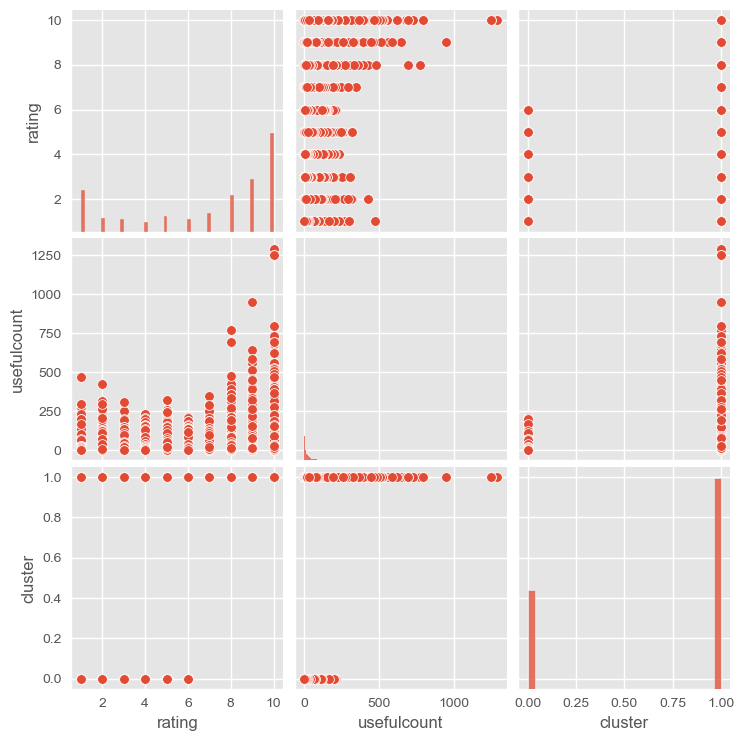

In [481]:
sns.pairplot(reviews_k2);

In [482]:
print(reviews_k2.groupby(['cluster']).mean())

           rating  usefulcount
cluster                       
0        2.651372    14.471130
1        9.033894    34.360275


In [483]:
reviews_k2.cluster.value_counts(normalize = True)

1    0.680453
0    0.319547
Name: cluster, dtype: float64

One cluster has low average ratings and useful counts (approximately 1/3 of reviews.)

The other cluster has an average high rating and useful count (approximately 2/3 of reviews),

I will determine the silhoutte score below.

In [484]:
silhouette_score(X, km.labels_)

0.5213553594485759

The score is higher than 0.5, so the structures are moderately well-defined.

I will determine the optimal k value below.

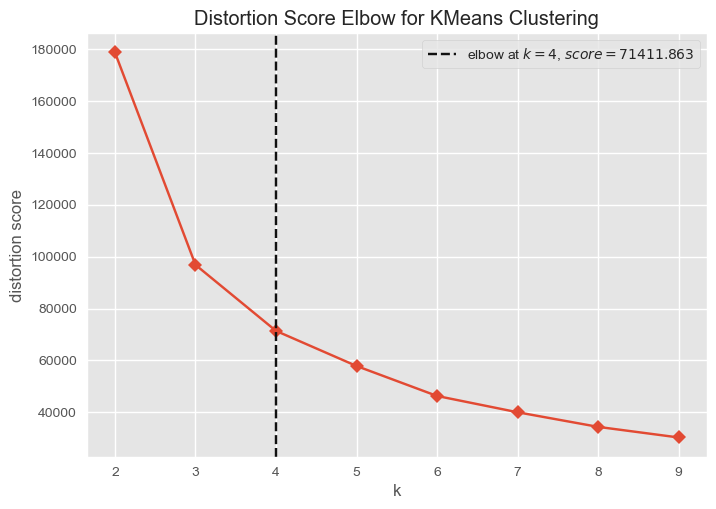

In [485]:
model = KMeans()

visualizer =  KElbowVisualizer(model, k=(2,10),timings=False)
visualizer.fit(X)
visualizer.show();

A K value of 4 is recommended.

##### Re-instantiate & Fit

In [486]:
km = KMeans(n_clusters = 4, random_state = 6789) 
km.fit(X)

KMeans(n_clusters=4, random_state=6789)

In [487]:
km.cluster_centers_

array([[ 0.56934503, -0.32912118],
       [ 0.62941596,  1.18808602],
       [-1.41476876, -0.37651367],
       [ 0.59401198,  4.32097771]])

In [488]:
reviews_k4 = reviews_k.copy()

reviews_k4['cluster'] = km.labels_
reviews_k4.head()

rating  usefulcount  cluster
drug                                             
Medroxyprogesterone    10.0           11        0
Medroxyprogesterone     8.0            7        0
Medroxyprogesterone     9.0           12        0
Medroxyprogesterone     1.0            4        2
Medroxyprogesterone     5.0            6        2

In [489]:
ss.inverse_transform(km.cluster_centers_)

array([[  8.85745542,  16.02354962],
       [  9.05402666,  71.25539877],
       [  2.36480204,  14.29829105],
       [  8.93817357, 185.30402723]])

In [490]:
centroids = pd.DataFrame(ss.inverse_transform(km.cluster_centers_))

centroids

0           1
0  8.857455   16.023550
1  9.054027   71.255399
2  2.364802   14.298291
3  8.938174  185.304027

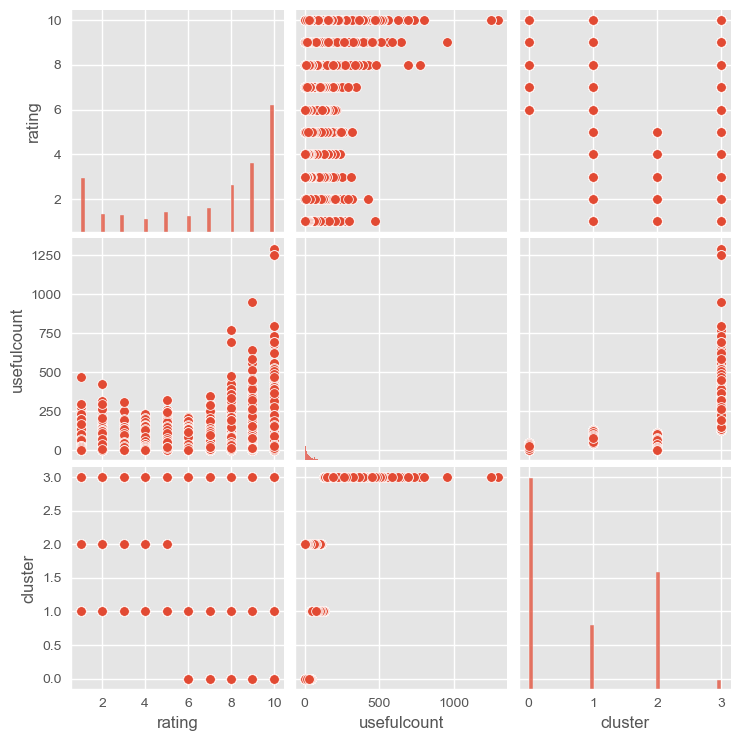

In [491]:
sns.pairplot(reviews_k4);

In [492]:
print(reviews_k4.groupby(['cluster']).mean())

           rating  usefulcount
cluster                       
0        8.857455    16.023550
1        9.054027    71.255399
2        2.364802    14.298291
3        8.938174   185.304027


In [493]:
reviews_k4.cluster.value_counts(normalize = True)

0    0.527053
2    0.292039
1    0.159048
3    0.021860
Name: cluster, dtype: float64

In [494]:
silhouette_score(X, km.labels_)

0.5437872935058042

Increasing the k value led to further definition of the clusters, with a silhoutte score of 0.544. Analyzing specifics of each cluster could prove useful in providing insights.

*All K Means clustering using the pain dataset, entire dataset, and all subsets engendered silhoutte scores that were above 0. Most frequently, use of the elbow method led to recommendations of 4 groups. Often, one cluster had a useful count far above the other 3 clusters. Additionally, three clusters would have high mean ratings , and one would have a low mean rating. One of the high mean rating groups would have a strongly negative compound score, another would have a moderately negative compound score, one would have a mildly negative compound sentiment score, and one would have a positive compound score. It could be of use to look into these further to determine, for example, what makes a review useful to patients? What accounts for the differences in mean sentiment scores between posts with similar mean ratings? After re-adding the review text to the dataframes, each cluster could be explored fully.*

## Conclusion, Recommendations & Next Steps

The findings of this study include information such as most commonly reviewed, highly rated, and lowly rated drugs for each of the most common conditions. Information was also uncovered regarding which reviews patients find most useful, and introductory work on seeking reviews containing information about certain side effects of pain medications including withdrawal, nausea, drowsiness, and suicidal ideation. Additionally, NLP and Sentiment Analysis revealed differences between reviews of some of the pain medications, such as Oxycodone and Tramadol. All K-Means clustering with the entire dataset and various subsets engendered silhoutte scores that were above 0. Most frequently, use of the elbow method led to recommendations of 4 groups, with silhoutte scores as high as 0.544. More in-depth study of the sentiments and language within the reviews, and trends within each cluster, could provide valuable information that providers and/or companies could use to assist patients.

In analyzing reviews, and the ways in which people express themselves through text and numerical ratings, there is a world of information that can be discovered. Patient reviews of drugs are certainly important, as they provide firsthand, descriptive accounts of experiences with specific drugs. With the plethora of drugs that can be prescribed and taken, it is best for as much information as possible to be used in order to give patients the best treatment possible. The preliminary information gathered in this study could be used to provide insight into medication options, and expected side effects. Additionally, the useful count informatation could be used to determine what information patients need. I plan to move forward by seeking opportunities to use patient reviews and other data to improve patient outcomes.